

- [Time series analysis and seasonality](#Time-Series-Seasonality)
- [Time series forecasting](#Time-Series-Forecasting)
- [Frequency domain analysis](#Frequency-domain-analysis)
- [Dynamic time warping](#Dynamic-time-warping)
- [K-means clustering](#Kmeans-clustering)
- [Silhouette plots](#Silhouette-plots)
- Q/A time
-------


In [3]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from datetime import datetime
import requests
from io import BytesIO
import seaborn

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, periodogram
from statsmodels.graphics.gofplots import qqplot


import sklearn
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn import datasets
from pandas.plotting import scatter_matrix, parallel_coordinates, andrews_curves

from IPython import display
from IPython.core.display import Image

from dtw import dtw

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

/Users/Shaun/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

In [5]:
def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<a id='Time-Series-Seasonality'></a>


Seasonality in time series
=====

[Back to top](#top)

The "Airline Data"- Dataset Series G of Chapter 9 of Box, Jenkins and Reinsel "Time Series Analysis, Forecasting and Control", Third Edition.
  - The classical example for showing the identification of seasonal models

In [7]:
# Starting over with Airline data
#air2 = pd.read_csv("AirPassengers.csv", header = 0, parse_dates = [1], names = ['air', 'time'], index_col = 1)

air2 = requests.get('http://www.stata-press.com/data/r12/air2.dta').content
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime(data.time[0], 1, 1), periods=len(data), freq='MS')

In [8]:
data.head()

air         time    t
1949-01-01  112  1949.000000  1.0
1949-02-01  118  1949.083374  2.0
1949-03-01  132  1949.166626  3.0
1949-04-01  129  1949.250000  4.0
1949-05-01  121  1949.333374  5.0

In [9]:
data['logair'] = np.log(data['air'])
data['dlogair']= data['logair'].diff()
data.dropna(inplace=True)
data.head()

air         time    t    logair   dlogair
1949-02-01  118  1949.083374  2.0  4.770685  0.052186
1949-03-01  132  1949.166626  3.0  4.882802  0.112117
1949-04-01  129  1949.250000  4.0  4.859812 -0.022990
1949-05-01  121  1949.333374  5.0  4.795791 -0.064022
1949-06-01  135  1949.416626  6.0  4.905275  0.109484

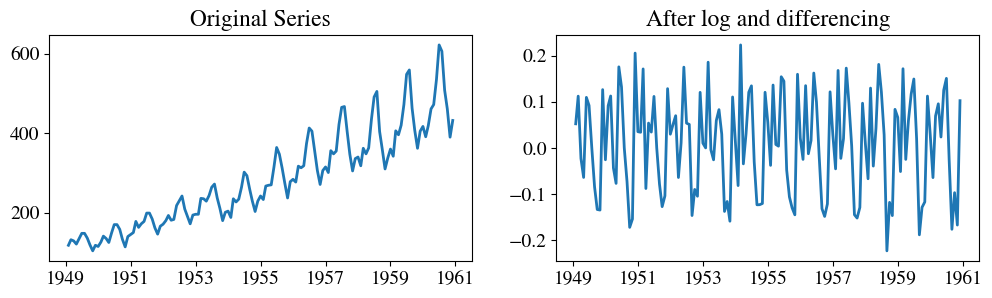

In [10]:
#Plot the data
f, ax = plt.subplots(1, 2,figsize=(12, 3))
ax[0].plot(data['air']);
ax[0].set_title('Original Series')
ax[1].plot(data['dlogair']);
#ax[1].plot(log_air_passengers_diff);
ax[1].set_title('After log and differencing');

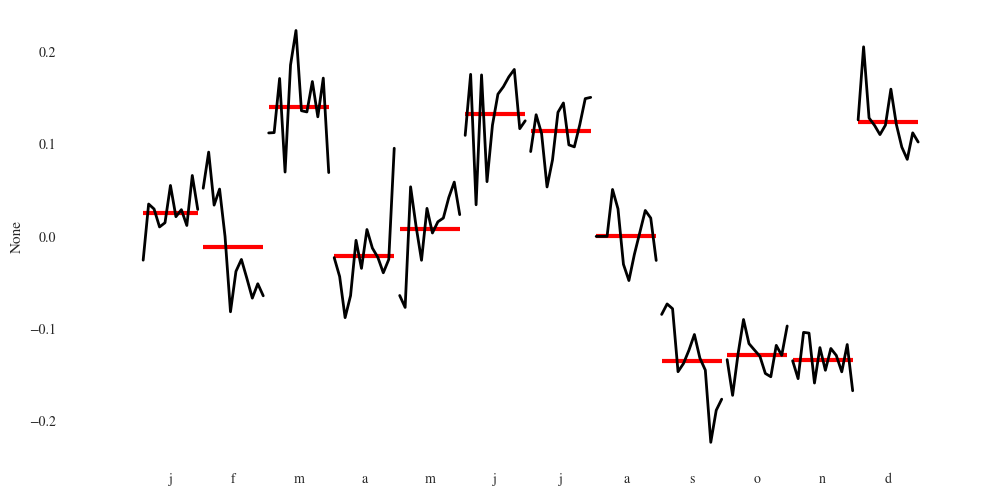

In [9]:
_ = smg.tsa.month_plot(data['dlogair'])

## Seasonal Decomposition

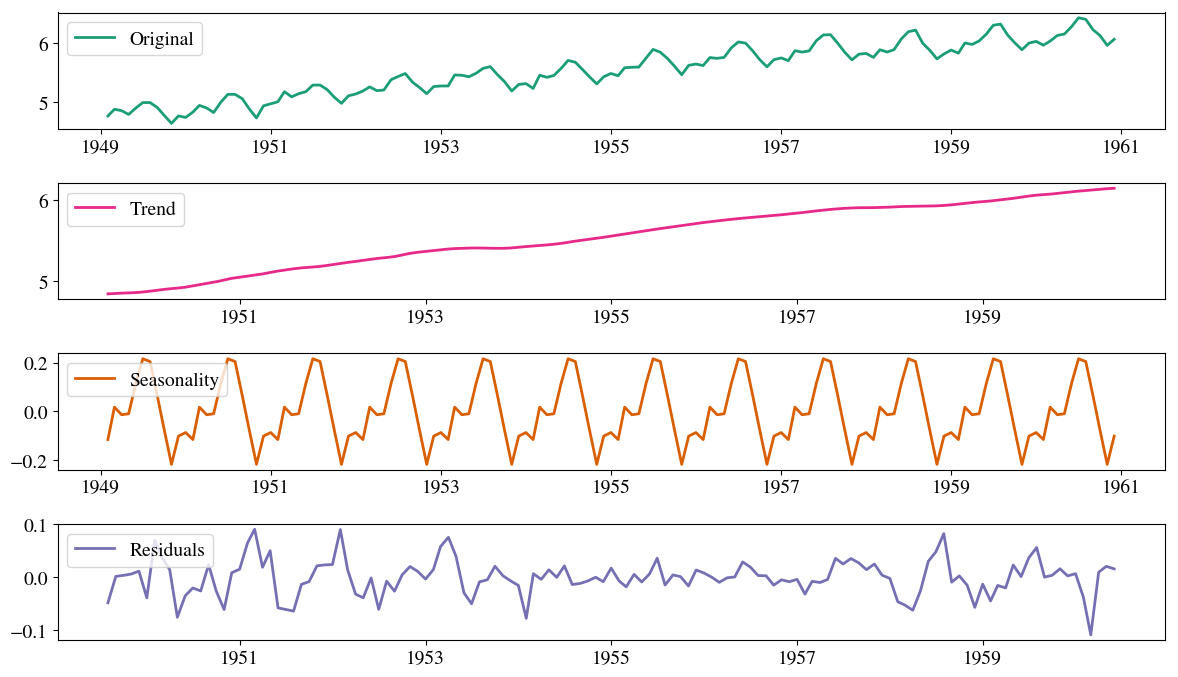

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['logair']) # try both data['air'] and  data['logair']

f, ax = plt.subplots(1,4,figsize=(12, 7))

plt.subplot(411)
plt.plot(data['logair'], label='Original', c=dark2_colors[0])
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
plt.legend(loc='upper left')
plt.tight_layout()

#### From last week's section
Let's look at the residuals to see if they are stationary

In [ ]:
seaborn.set(style='ticks', context='talk')

def tsplot(y, lags=None, figsize=(12, 12)):
    
    q, p = sm.stats.diagnostic.acorr_ljungbox(y,lags)
    fig = plt.figure(figsize=figsize)
    layout = (4, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2, title='QQ plot')
    lbox_ax = plt.subplot2grid(layout, (3, 0), colspan=2, title='Ljung-Box statistic')

    y.plot(ax=ts_ax, title='Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    qqplot(y,  line='q', ax=qq_ax, fit=True)
    if np.max(p) > 0.05:
        lbox_ax.axhline(y=0.05, xmin=0, xmax=lags, c ='r')
    lbox_ax.plot(p)
    seaborn.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax, lbox_ax

### Let's plot the first-differenced series again and look at the ACF and PACF plots

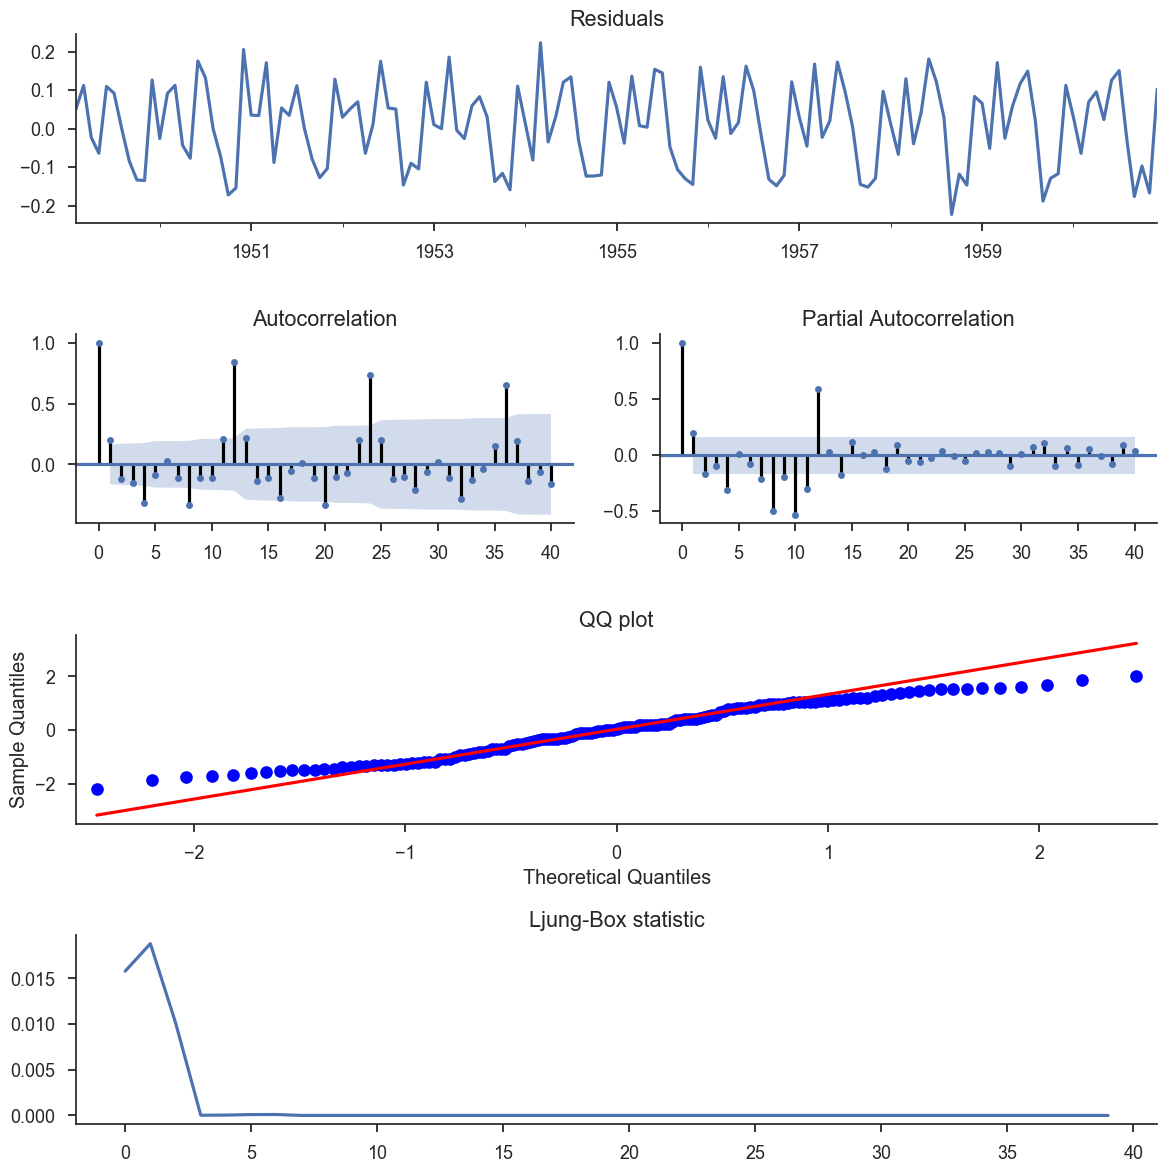

In [12]:
_ = tsplot(data['dlogair'] , 40)

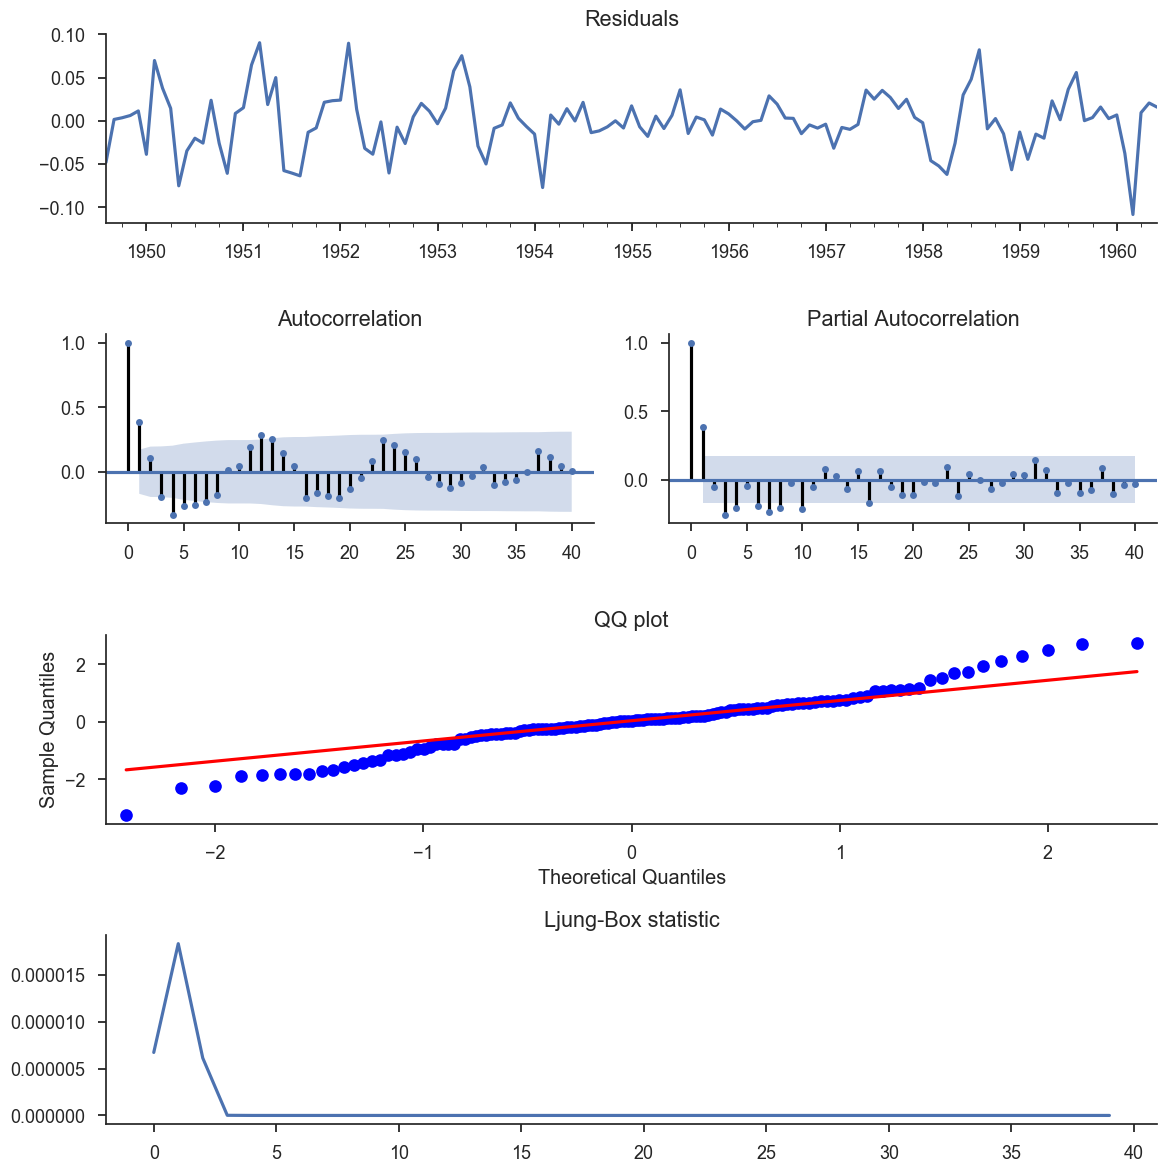

In [13]:
decomp_resid = decomposition.resid
decomp_resid.dropna(inplace=True)
_ = tsplot(decomp_resid, 40)

In [12]:
# Fit an ARIMA model to the log of air passengers

#mod = smt.ARIMA(data['logair'], order=(0,1,1))
#mod = sm.tsa.statespace.SARIMAX(data['logair'], order=(0,1,1), simple_differencing=True)
#mod = sm.tsa.statespace.SARIMAX(data['logair'], order=(0,1,1), seasonal_order=(0,1,0,12), simple_differencing=True)
#mod = sm.tsa.statespace.SARIMAX(data['logair'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
mod = sm.tsa.statespace.SARIMAX(data['logair'], order=(0,1,1), seasonal_order=(0,1,2,12), simple_differencing=True)
#mod = smt.SARIMAX(data['logair'], order=(0,1,1), seasonal_order=(0,1,1,12))
#mod = smt.SARIMAX(data['logair'], order=(1, 1, 1), seasonal_order=(1, 1, 2, 12))

results_ARIMA = mod.fit()
print (results_ARIMA.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      D.DS12.logair   No. Observations:                  130
Model:             SARIMAX(0, 0, 1)x(0, 0, 2, 12)   Log Likelihood                 242.609
Date:                            Sat, 30 Sep 2017   AIC                           -477.219
Time:                                    08:44:53   BIC                           -465.749
Sample:                                03-01-1950   HQIC                          -472.558
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4169      0.074     -5.669      0.000      -0.561      -0.273
ma.S.L12      -0.5950      0.096   

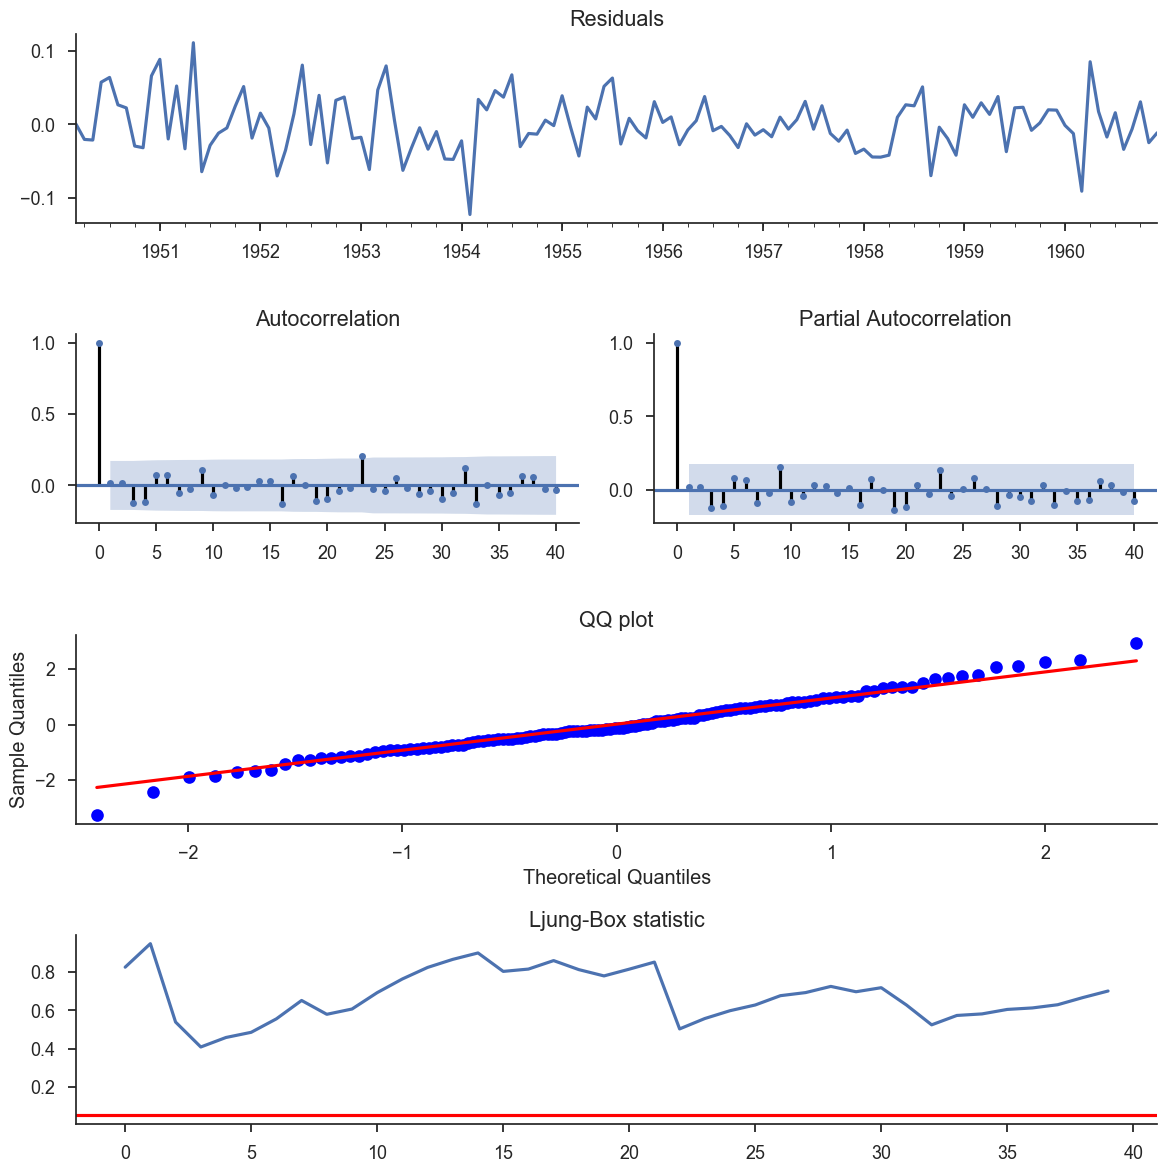

In [15]:
_ = tsplot(results_ARIMA.resid, 40)

<a id='Time-Series-Forecasting'></a>


Forecasting time series
=====

[Back to top](#top)


### The Sunspots dataset from Section 2 - with an ARIMA model with pdq (0,1,1) 

In [16]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del sunspots["YEAR"]

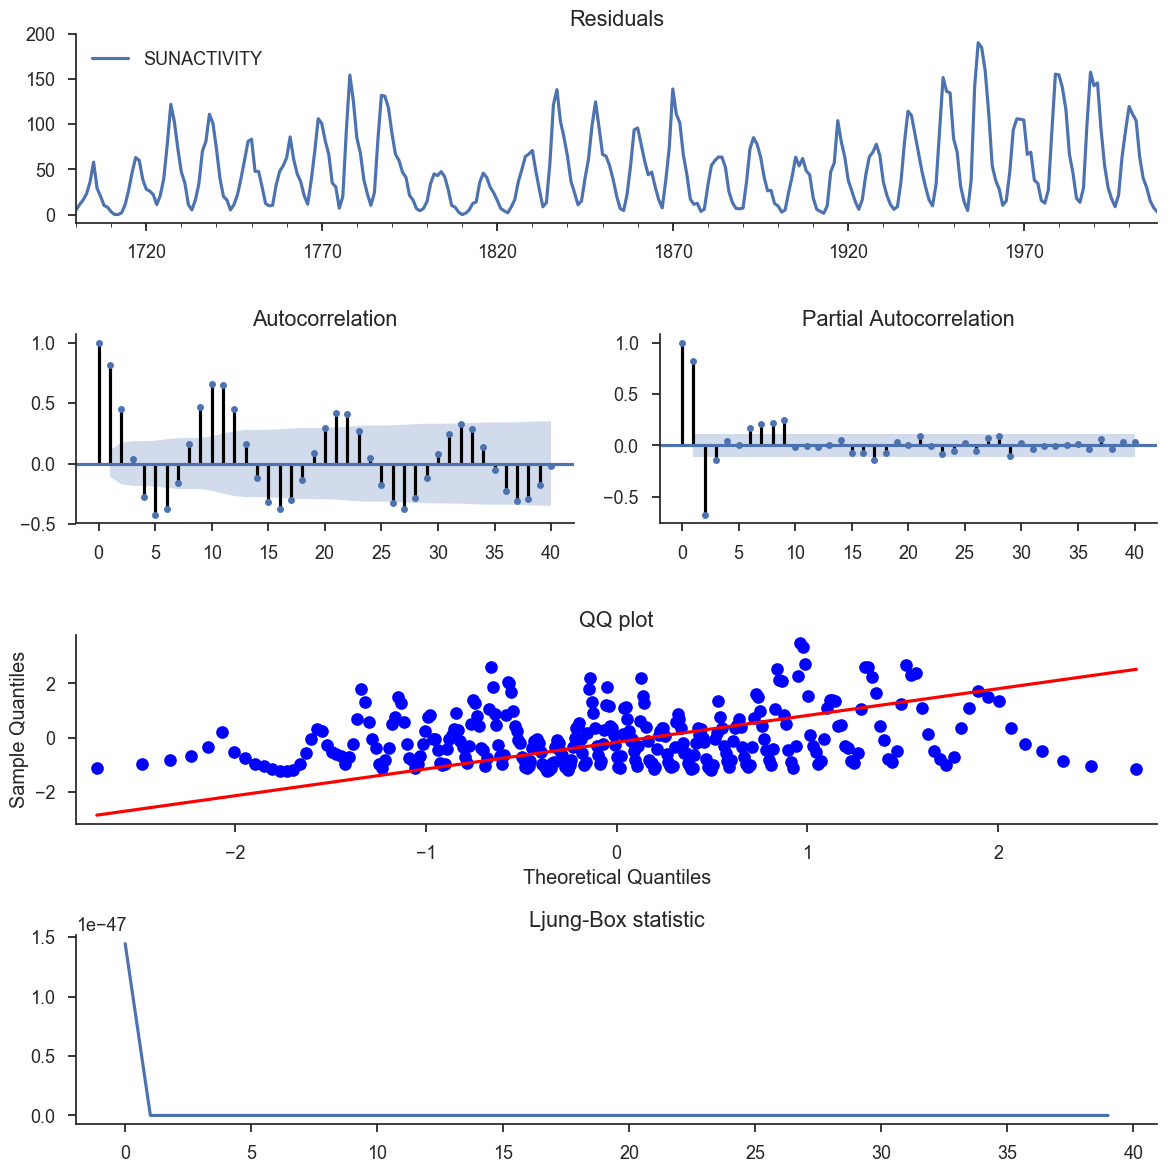

In [17]:
_ = tsplot(sunspots, 40)

In [18]:
results_ARIMA = ARIMA(sunspots.SUNACTIVITY, order=(3,0,3)).fit(disp=-1)    #2,0,2  #4,0,4 #3,0,3 #2,1,2

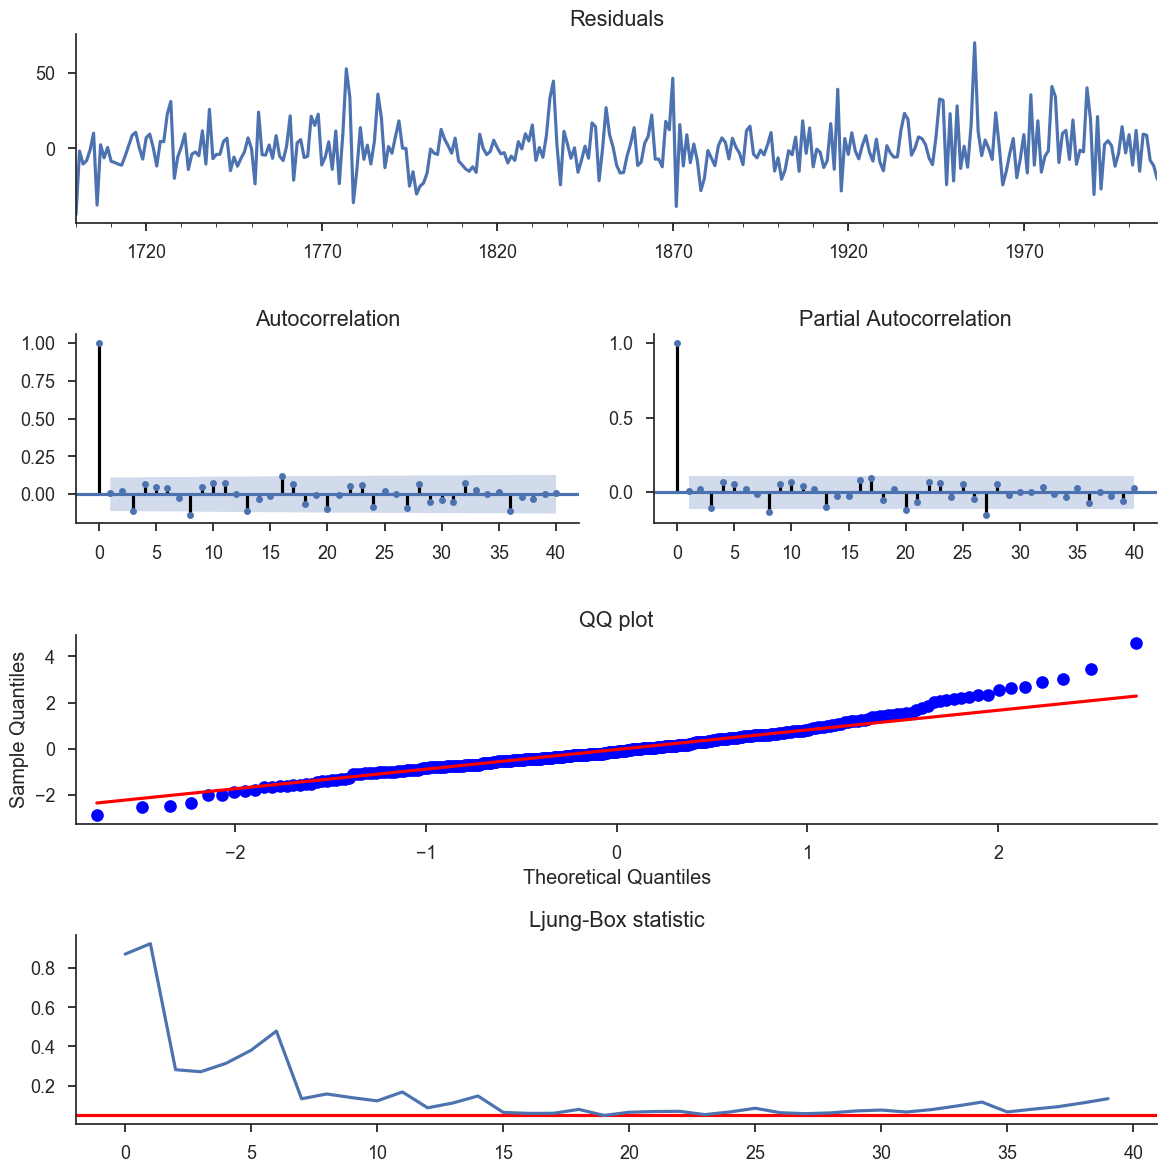

In [19]:
_ = tsplot(results_ARIMA.resid, 40)

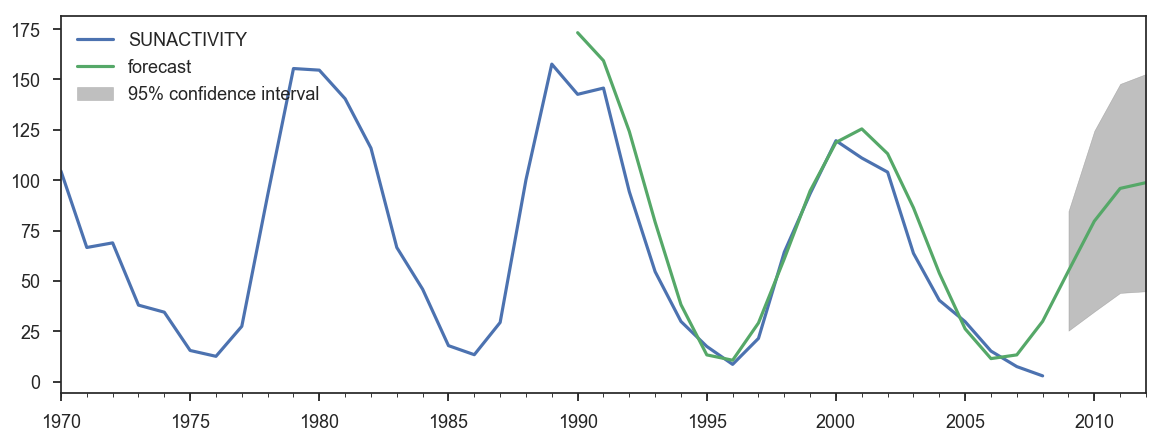

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))
ax = sunspots['1970':].plot(ax=ax)
fig = results_ARIMA.plot_predict('1990-12-31', '2012-12-31', dynamic=True, ax=ax, plot_insample=False)
legend = ax.legend(loc='upper left')

In [21]:
def root_mean_forecast_err(y, yhat):
    return np.sqrt(np.mean((y.sub(yhat))**2))

predict_sunspots = results_ARIMA.predict('1990', '2008', dynamic=True)
root_mean_forecast_err(sunspots.SUNACTIVITY, predict_sunspots)

15.492508433777664

## Forecasting the Air Data series -

### First with a simple ARIMA model -  pdq = (0,1,1,) 

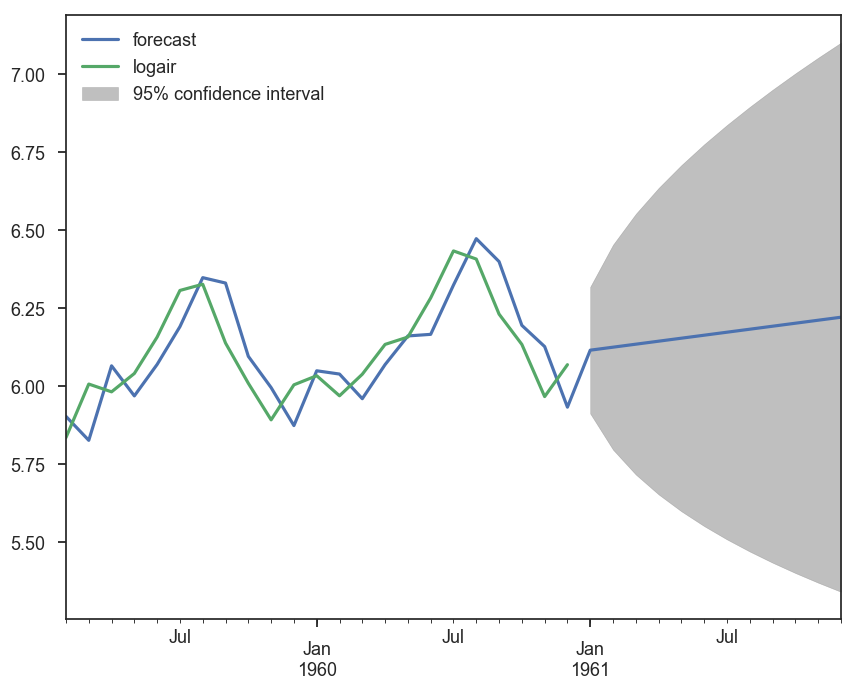

In [22]:
results_ARIMA = sm.tsa.ARIMA(data.logair, order=(0,1,1)).fit()

fig, ax = plt.subplots(figsize=(10,8))
#fig = results_ARIMA.plot_predict(start = '1959-02-01', end= '1961-12-01', dynamic=True , ax=ax)
fig = results_ARIMA.plot_predict(start = '1959-02-01', end= '1961-12-01',  ax=ax)
legend = ax.legend(loc='upper left')

###  Then with a SARIMA model -  pdq = (0,1,1,)   PDQ(0,1,1,12)

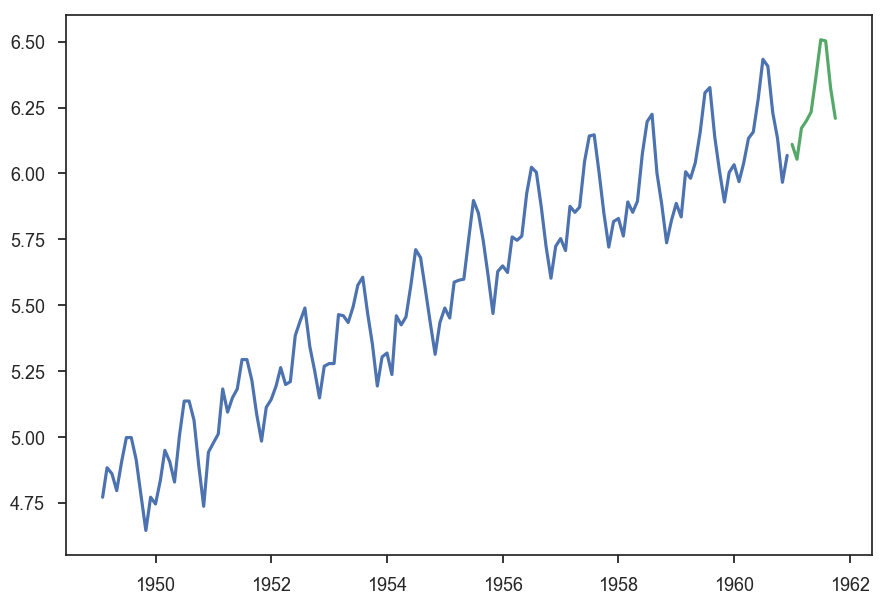

In [23]:
results_ARIMA = sm.tsa.SARIMAX(data['logair'], order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
pred = results_ARIMA.forecast(steps=10, dynamic= True)  
plt.plot(data['logair'])
plt.plot(pred);

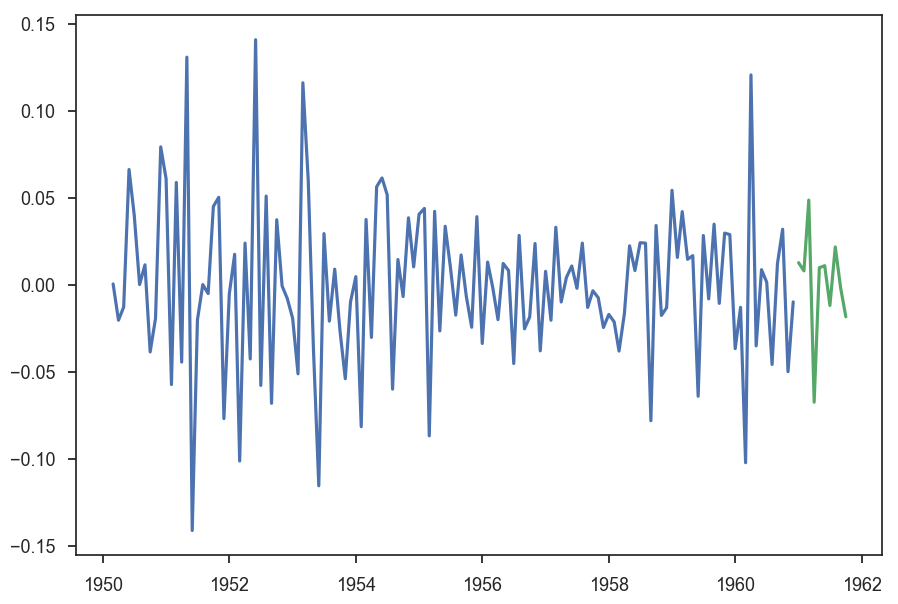

In [24]:
results_ARIMA = smt.SARIMAX(data['logair'], order=(0,1,1), seasonal_order=(0,1,1,12), simple_differencing=True).fit()
pred = results_ARIMA.forecast(steps=10, dynamic= True)  
shifted = lambda x: x - x.shift(-1) - x.shift(-12) + x.shift(-13)

plt.plot(shifted(data['logair']).shift(13))
plt.plot(pred);

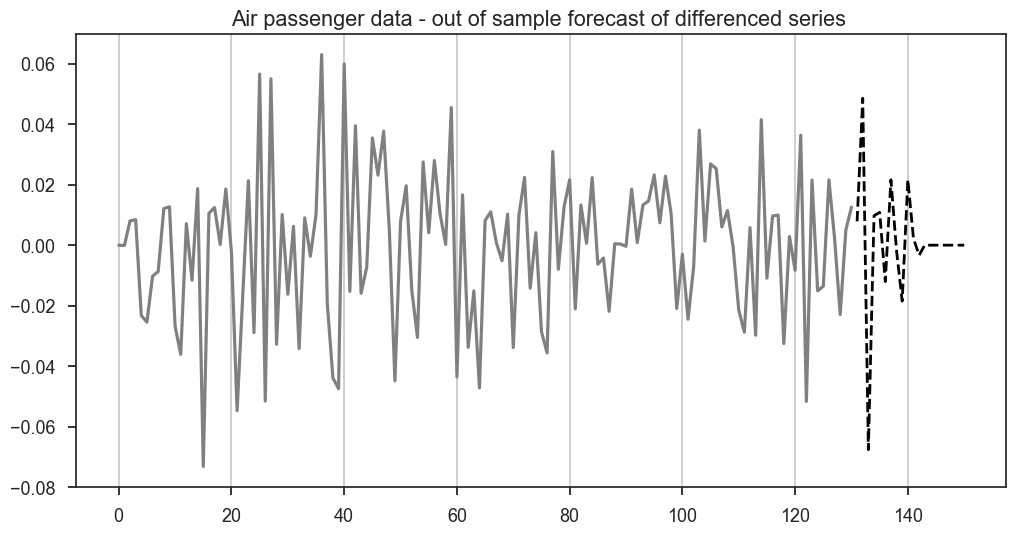

In [25]:
#  From the example notebook of Chad Fulton
# http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_internet.html

# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 20
predict = results_ARIMA.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)

ax.set(title='Air passenger data - out of sample forecast of differenced series ');

Another famous dataset - the Canadian lynx data
======

Let's plot it out with the plotting that we define above for residuals

In [26]:
lynx = pd.read_csv("lynx.csv", header = 0, parse_dates = [1], names = ['idx', 'trapped'], index_col = 1)
lynx.drop('idx', inplace=True, axis=1)
lynx['trapped'] = np.log(lynx['trapped'].astype(float))
lynx.head()

trapped
1821-01-01  5.594711
1822-01-01  5.771441
1823-01-01  6.371612
1824-01-01  6.769642
1825-01-01  7.296413

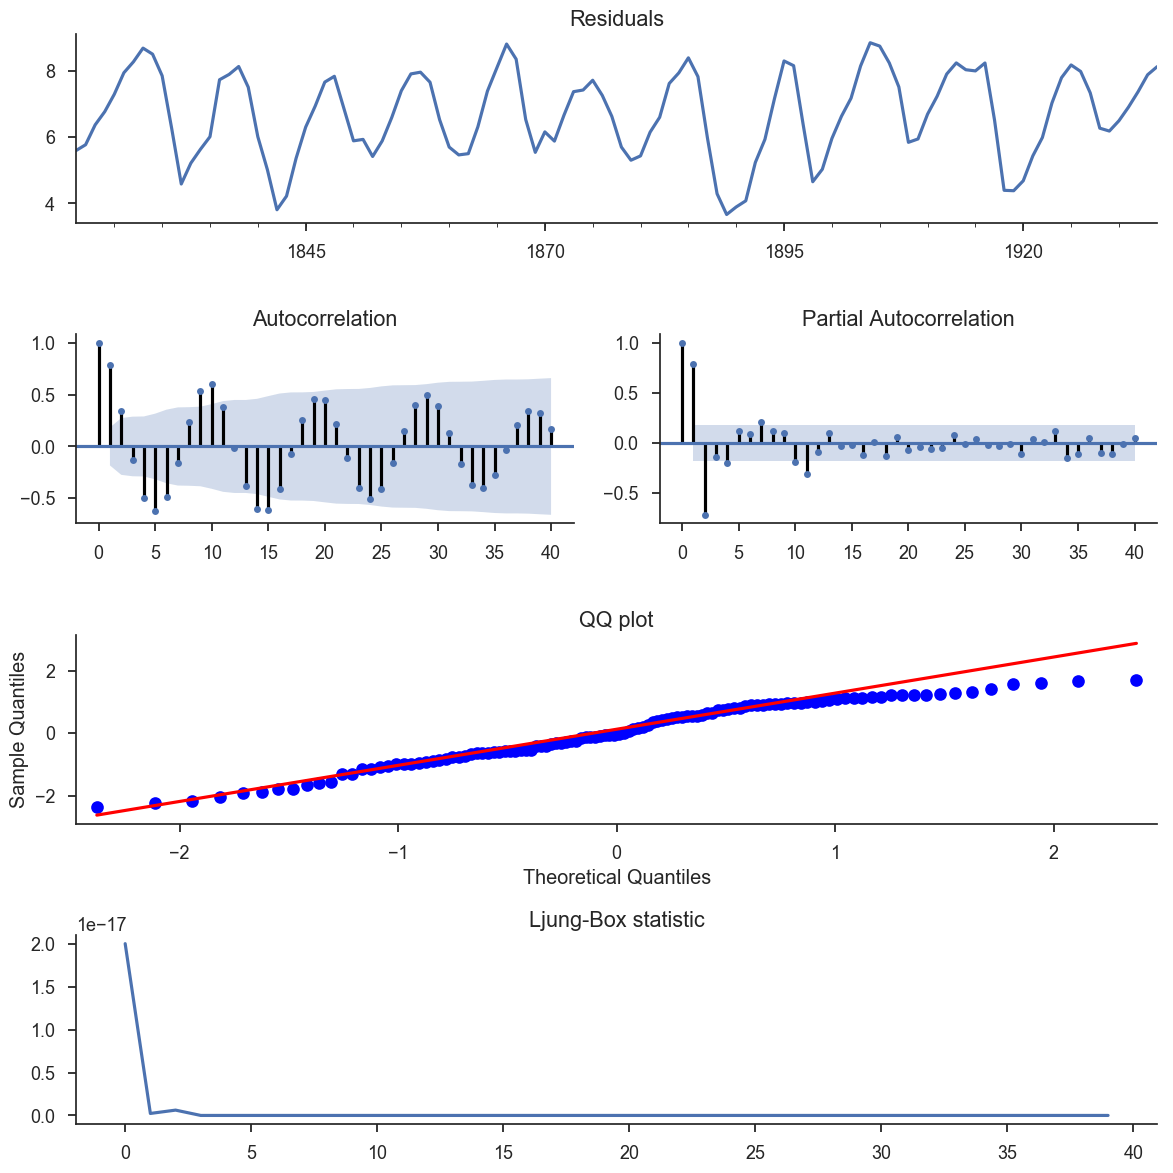

In [27]:
_ = tsplot(lynx['trapped'], 40)

In [28]:
results = smt.ARIMA(lynx['trapped'], order=(11,0,0)).fit(trend = 'nc')
#results = smt.ARIMA(lynx['trapped'], order=(2,0,0)).fit(trend = 'c')
print (results.summary())
print ( results.aic)

                              ARMA Model Results                              
Dep. Variable:                trapped   No. Observations:                  114
Model:                    ARMA(11, 0)   Log Likelihood                 -79.860
Method:                       css-mle   S.D. of innovations              0.468
Date:                Sun, 17 Sep 2017   AIC                            183.721
Time:                        22:33:29   BIC                            216.555
Sample:                    01-01-1821   HQIC                           197.047
                         - 01-01-1934                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.trapped      1.2581      0.088     14.311      0.000       1.086       1.430
ar.L2.trapped     -0.5896      0.144     -4.093      0.000      -0.872      -0.307
ar.L3.trapped      0.3200      0.155

In [29]:
results.aic

183.72091767549668

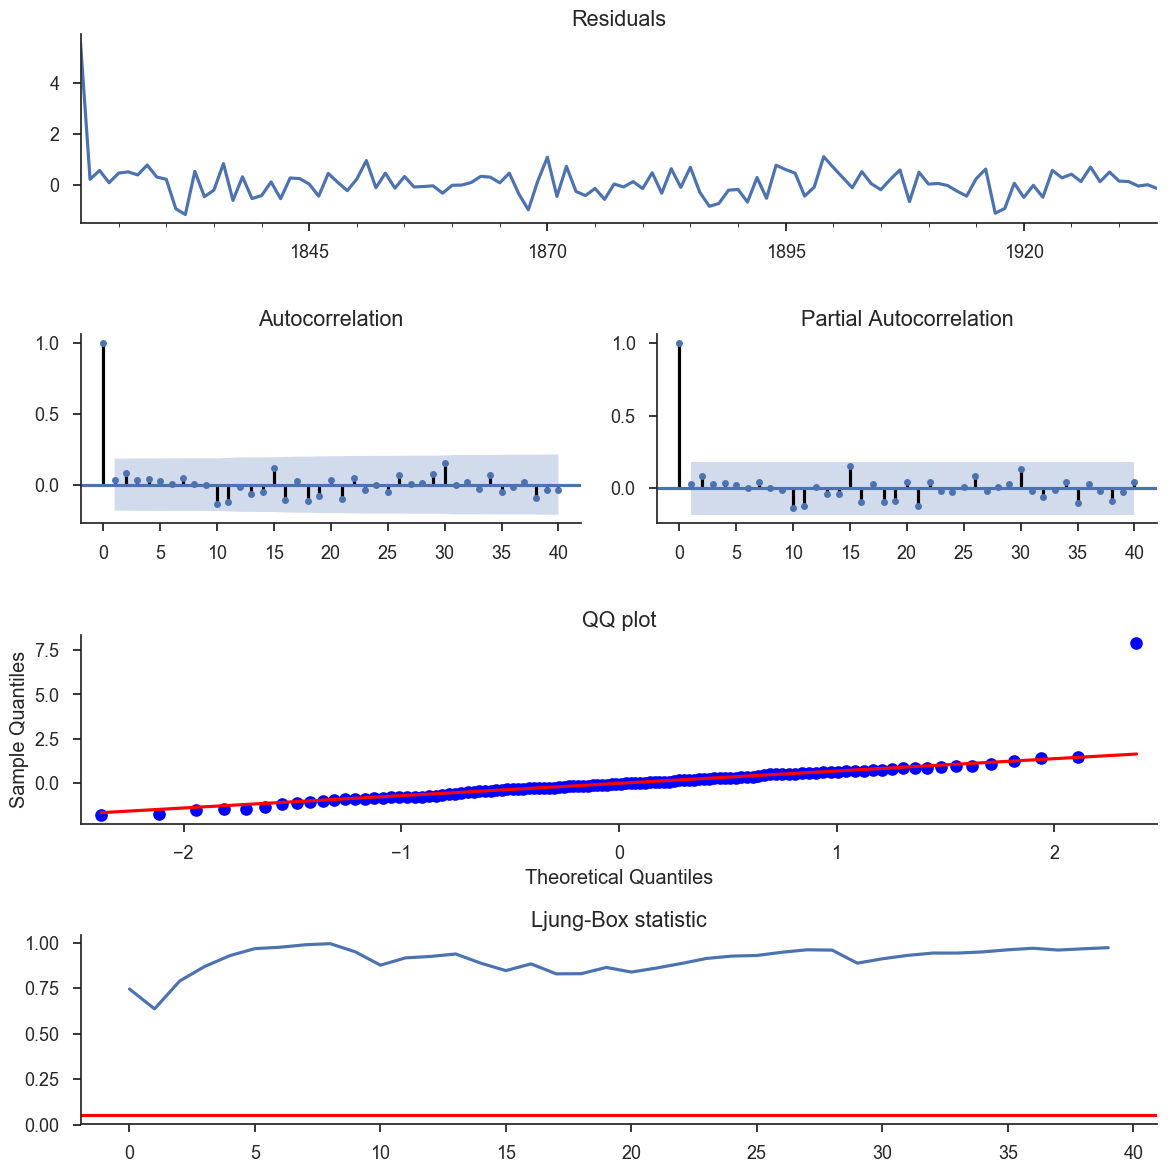

In [30]:
_ = tsplot(results.resid, 40)

### History -
Moran (1953) fitted an AR(2) model with an intercept, but found that one-step prediction was not good.  Tong (1977) looked at many models, and arrived at an AR(11) model without an intercept.  

Actually, the data have a cycle of about 10 years - but not always - sometimes 9 years, sometimes 11 years.

- How can we look at the cyclical nature of a series?

In [31]:
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()

<a id='Frequency-domain-analysis'></a>


Frequency domain analysis
=====

[Back to top](#top)

Frequency, or spectral, analysis is a distinct, but complementary path of analysis - based on characterizing the time series as a periodic signal, and analyzing the properties of that signal. The ultimate reference for this is the text (actually, two volumes) by Priestley "Spectral Analysis and Time Series".  Spectral analysis is simply an alternative representation of the autocovariance function time series that is covariance stationary.

Let's look at the idea with a purely periodic signal, and the Discrete Fourier Transform (DFT), which converts the series in the time domain to the frequency domain.  

$$ f(t) = \sin (10 \cdot 2 \cdot \pi \cdot t) $$

Here $10$ is the frequency of the signal - the number of cycles per second (Hertz) - so we are generating a series that cycles 10 times a second. Alternatively, we can think of the period - 1 /  frequency - as the "repeat" in the signal. In our example, the period is 1/10 seconds.

Last - in order to plot our continuous signal, we need to sample it. So, we choose a sampling rate, $100$, which just means measure the signal 100 times a second. 

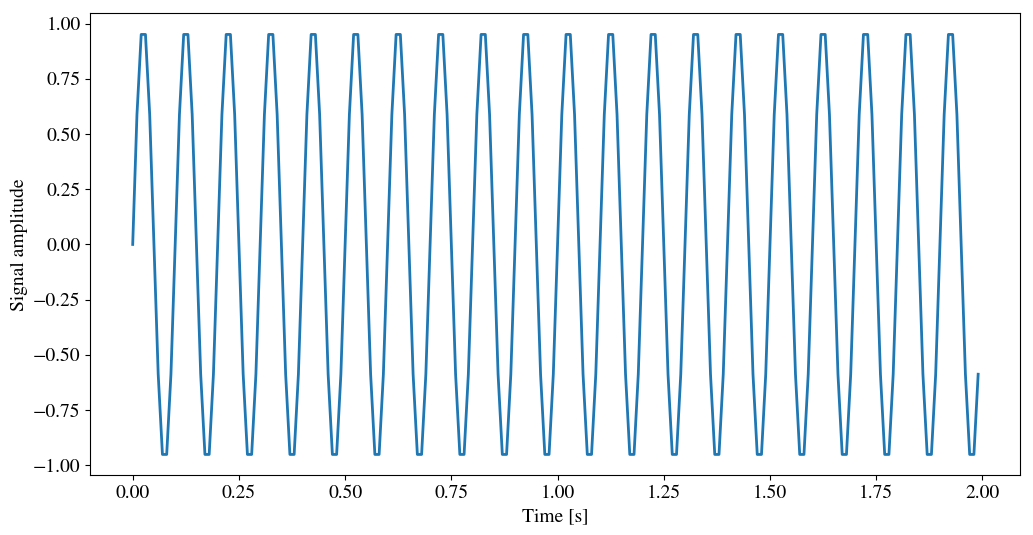

In [32]:
frequency = 10  
sampling_rate = 100 

t = np.linspace(0, 2, 2 * sampling_rate, endpoint=False)
x = np.sin(frequency * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

(-5, 110)

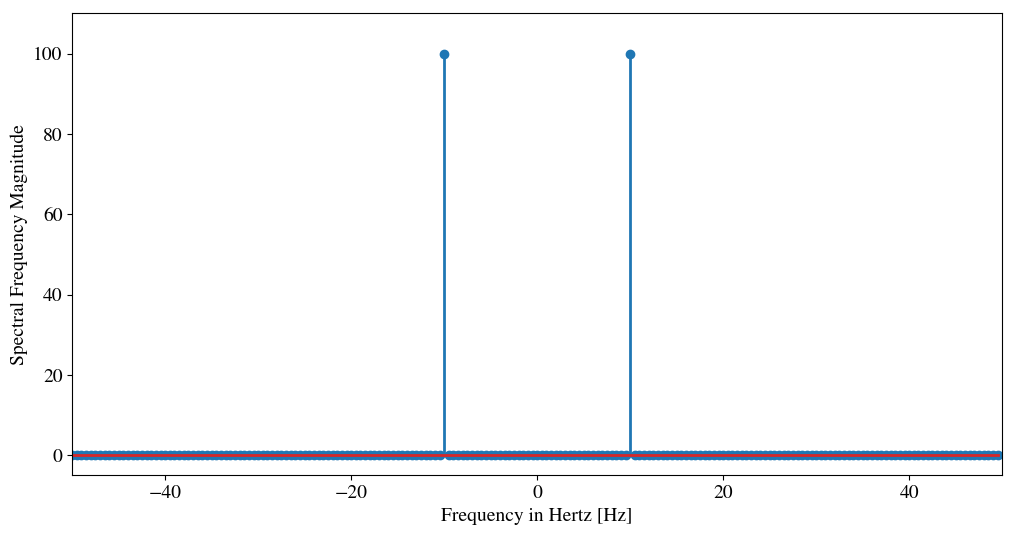

In [33]:
from scipy import fftpack

X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * sampling_rate

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Spectral Frequency Magnitude')
ax.set_xlim(-sampling_rate / 2, sampling_rate / 2)
ax.set_ylim(-5, 110)

## The periodogram

From [Penn state Time series course](https://onlinecourses.science.psu.edu/stat510/node/80):


**
... the periodogram, a function/graph that displays information about the periodic components of a time series.  Any time series can be expressed as a sum of cosine and sine waves oscillating at the fundamental (harmonic) frequencies = j/n, with j = 1, 2, …, n/2.  The periodogram gives information about the relative strengths of the various frequencies for explaining the variation in the time series.  **

**The periodogram is a sample estimate of a population function called the spectral density, which is a frequency domain characterization of a population stationary time series.  The spectral density is a frequency domain representation of a time series that is directly related to the autocovariance time domain representation.  In essence the spectral density and the autocovariance function contain the same information, but express it in different ways. **


Also:
[Thomas Sargents site](https://lectures.quantecon.org/py/estspec.html)

### The 'raw' periodogram - i.e. no smoothing


(200,)


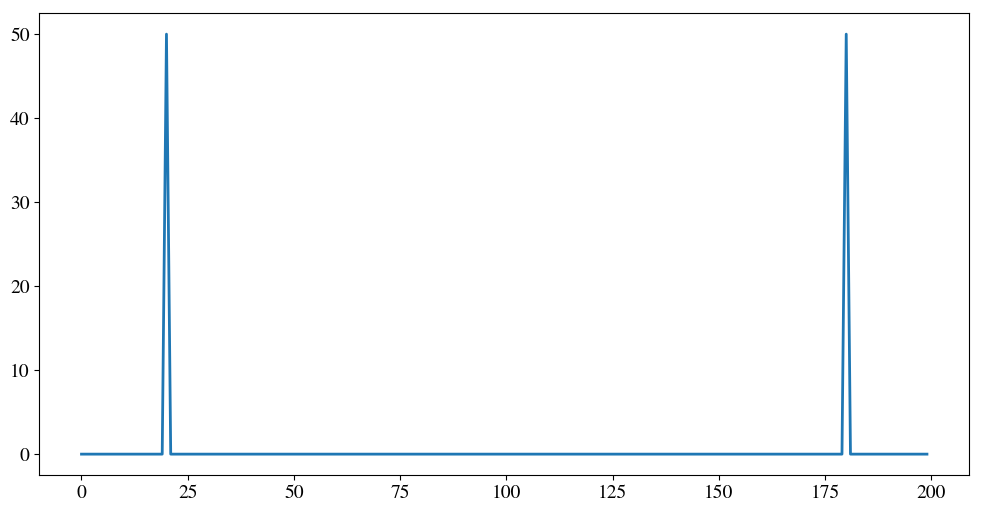

In [34]:
# periodogramme = lambda X: 1./len(X) * np.abs(np.fft.fft(X))**2
# freqs = np.abs(np.fft.fft(X))**2 / len(X)

pgram = periodogram(x)
print(pgram.shape)
plt.plot(pgram)

### Let's look at the frequency domain characteristics of the Lynx data

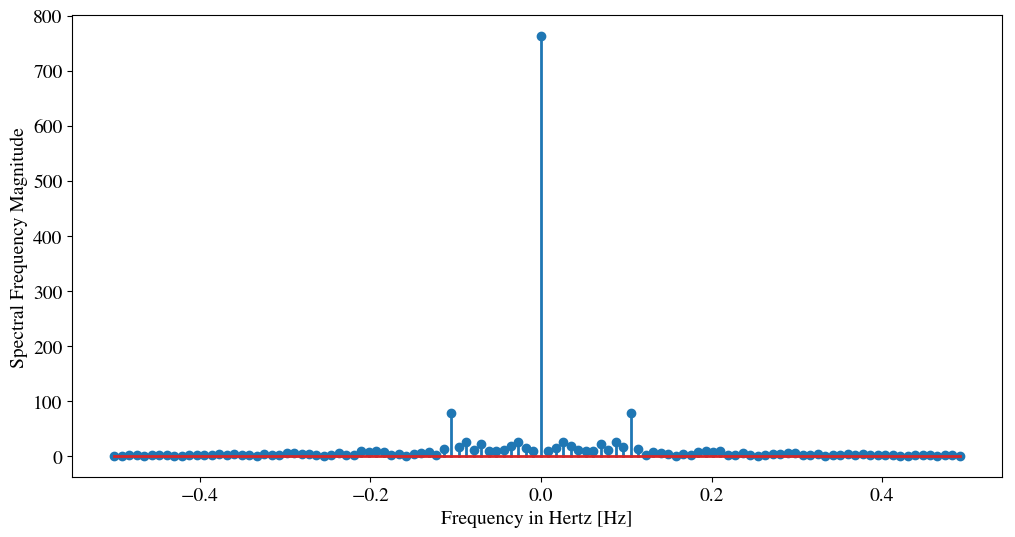

In [35]:
X = fftpack.fft(lynx['trapped'])
freqs = fftpack.fftfreq(len(lynx['trapped'])) 

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Spectral Frequency Magnitude')

(114,)


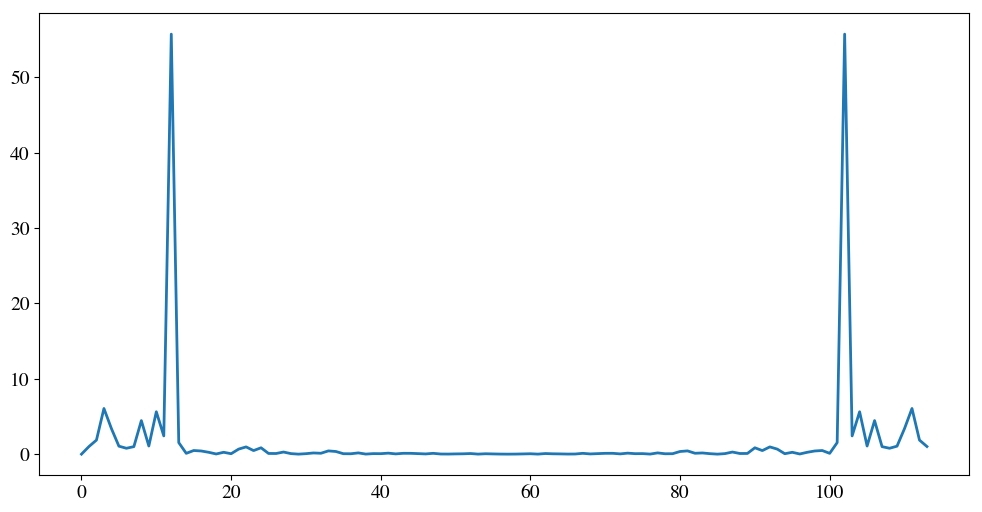

In [36]:
pgram = periodogram(lynx['trapped'])
print(pgram.shape)
plt.plot(pgram)

### Now let's generate an ARMA (2,0) process and see how it compares to the Lynx dataset

- series plot
- ACF, PACF
- QQ plot
- Ljung box

- Periodogram

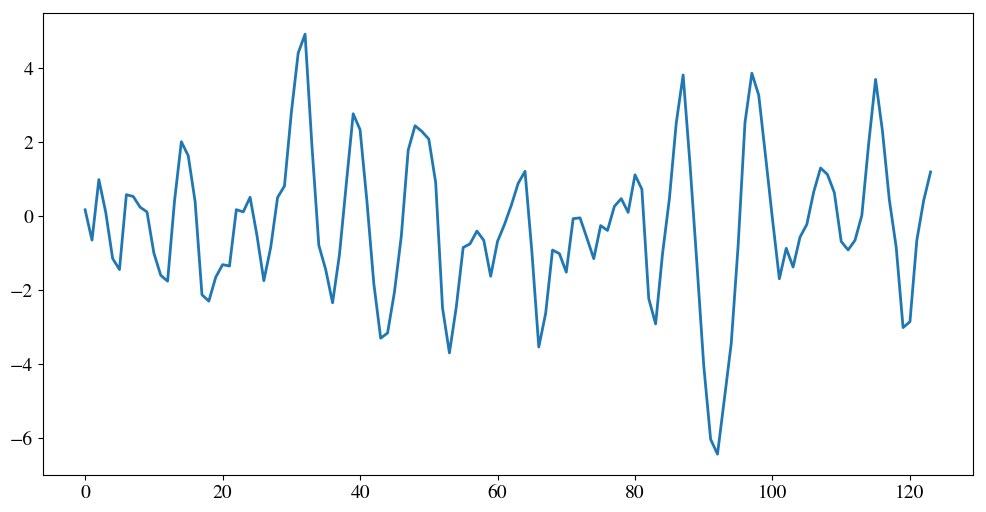

In [37]:
from statsmodels.tsa.arima_process import arma_generate_sample
arparams = np.r_[1, -np.array([1.38, -0.74])]
maparams = np.r_[1 ]

y = arma_generate_sample(arparams, maparams, 124)
plt.plot (y)

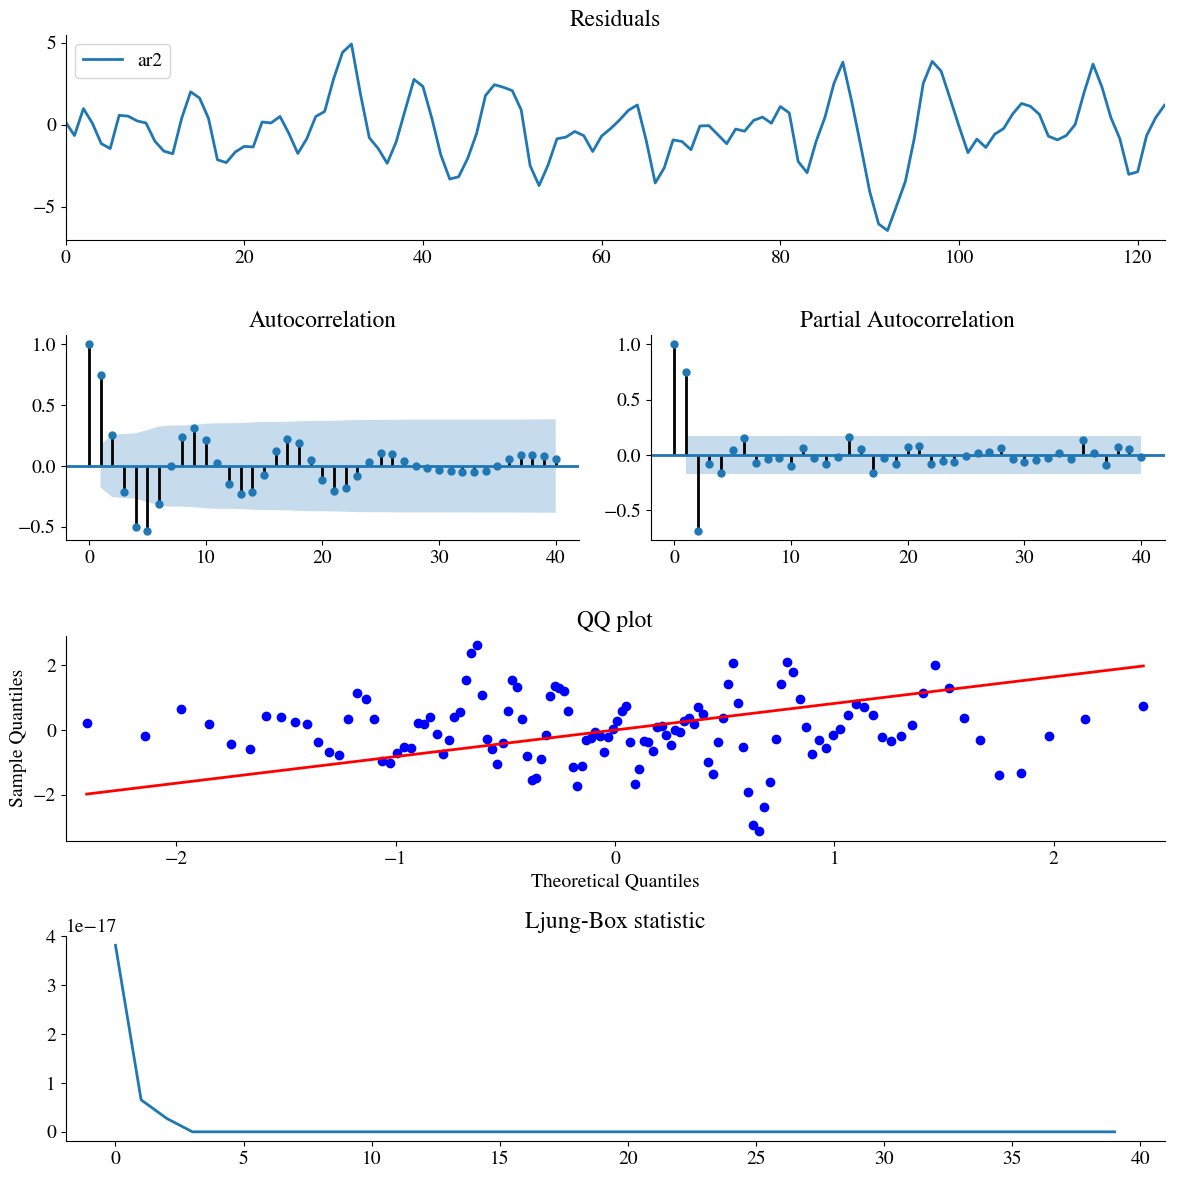

In [38]:
gendata = pd.DataFrame({'ar2':y})
_ = tsplot(gendata, 40)

In [39]:
#results = smt.ARIMA(lynx['trapped'], order=(2,0,0)).fit(trend = 'c')
results = smt.ARIMA(y, order=(2,0,0)).fit(trend = 'c')
print (results.summary())
print (results.aic)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  124
Model:                     ARMA(2, 0)   Log Likelihood                -168.708
Method:                       css-mle   S.D. of innovations              0.935
Date:                Sun, 17 Sep 2017   AIC                            345.416
Time:                        22:33:34   BIC                            356.698
Sample:                             0   HQIC                           349.999
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2500      0.198     -1.260      0.210      -0.639       0.139
ar.L1.y        1.2649      0.064     19.832      0.000       1.140       1.390
ar.L2.y       -0.6893      0.063    -10.902      0.0

(124,)


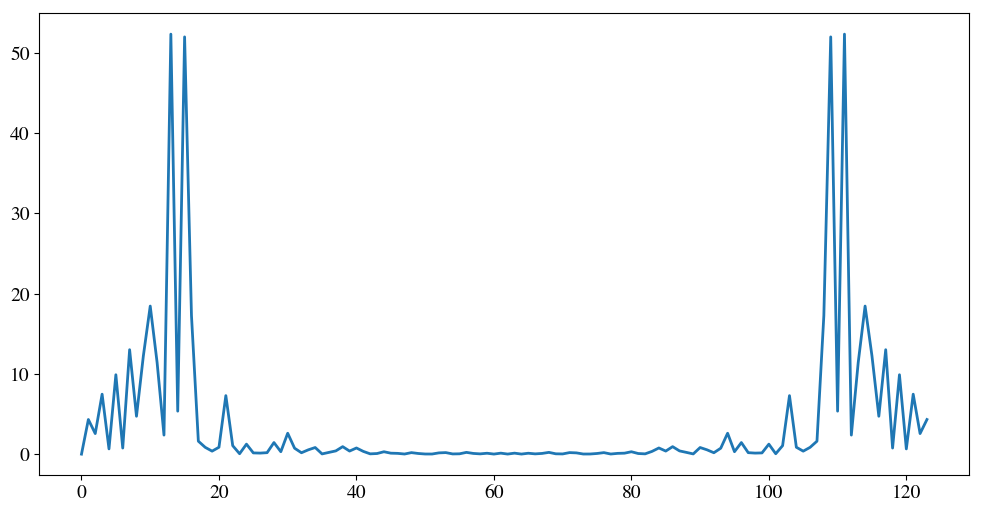

In [40]:
pgram = periodogram(y)
print(pgram.shape)
plt.plot(pgram)

<a id='Dynamic-time-warping'></a>


Dynamic Time Warping (DTW)
=====

[Back to top](#top)


based on the work of Pierre Rouanet  https://pypi.python.org/pypi/dtw/1.0

before running this example you need to install dtw   

`pip install dtw`

## DTW

The Dynamic Time Warping (DTW) distance measure is a technique that has long been known in speech recognition community.  It allows a non-linear mapping of one signal to another by minimizing the distance between the two.  A decade ago, DTW was introduced into Data Mining community as a utility for various tasks for time series problems including classification, clustering, and anomaly detection. The technique has flourished, particularly in the last three years, and has been applied to a variety of problems in various disciplines. 

$$ \text{cost }  = d(s(i), t(j)) $$

$$ DTW(i, j) = \text{cost } + \min \big( DTW(i-1, j), DTW(i , j-1), DTW(i-1, j-1) \big) $$

## A simple example with two generated time series

In [41]:
x = np.array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0, 4, 4, 0, -4, 0]).reshape(-1, 1)
y = np.array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0, 1, 3, 4, 3, 1, -1, -2, -1, 0, 2]).reshape(-1, 1)

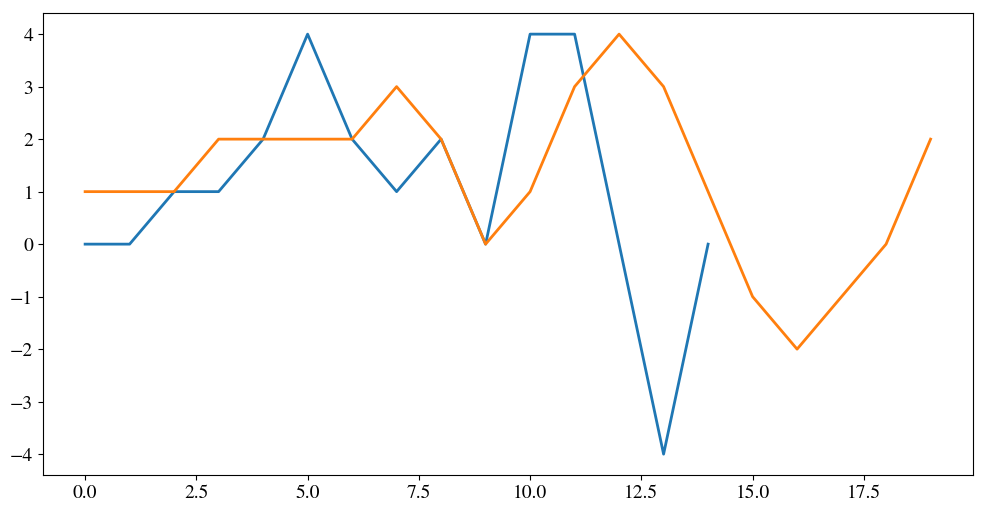

In [42]:
plt.plot(x)
plt.plot(y)

## Compute DTW

The `dtw()` function returns the distance, the cost, the accumulated cost and the shortest cost path

In [43]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [44]:
print ('Minimum distance found:', dist)
#print ('Cost matrix for path:\n', cost)
#print ('Accumulated cost matrix:\n', acc)

Minimum distance found: 0.4


## Use imshow to plot the accumulated cost matrix and a line corresponding to the shortest cost path.

(-0.5, 19.5)

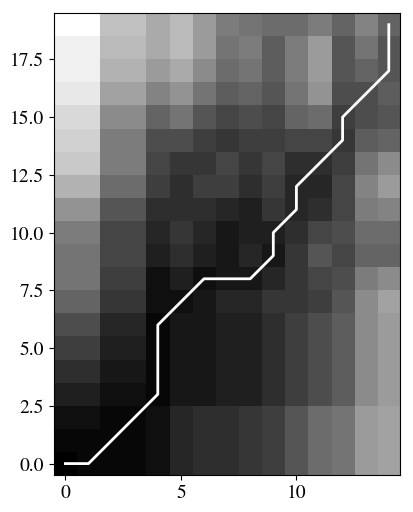

In [45]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"), interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

## Using another distance

You can specify your own distance used as the cost measure by the DTW. By default the L1 norm is used.

In [46]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: (x * x) + (y * y))

(-0.5, 19.5)

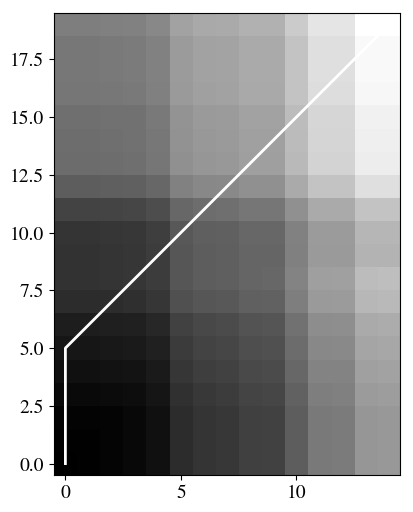

In [47]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"), interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

## Detecting subsequences  
The sequences used can be of different length. DTW can also be useful to detect subsequences.

In [48]:
y = [0] * 2 + x
#y =  [[0]*2] + y + [[0]*2]
y = np.array(y).reshape(-1, 1)

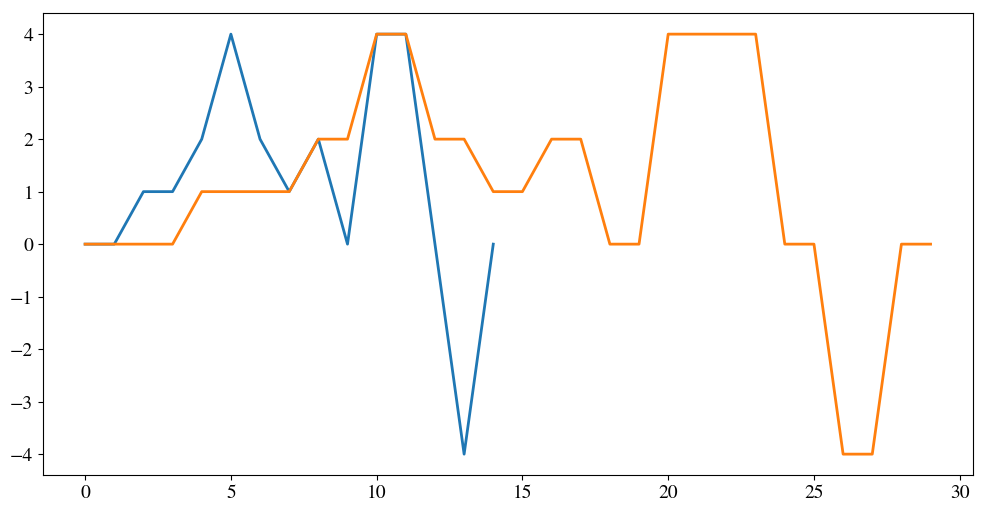

In [49]:
plt.plot(x)
plt.plot(y)

In [50]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [51]:
print ('Minimum distance found:', dist)

Minimum distance found: 0.0


(-0.5, 29.5)

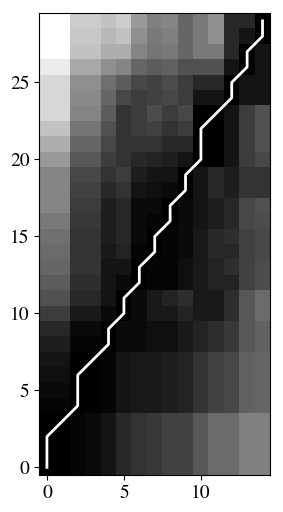

In [52]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"),  interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

### fastdtw

You might want to install the fastdtw package for dealing with longer series.

`pip install fastdtw`



In [53]:
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path2 = fastdtw(x, y, dist=euclidean)
print(distance)
print (path2)

0.0
[(0, 0), (0, 1), (0, 2), (1, 3), (2, 4), (2, 5), (2, 6), (3, 7), (4, 8), (4, 9), (5, 10), (5, 11), (6, 12), (6, 13), (7, 14), (7, 15), (8, 16), (8, 17), (9, 18), (9, 19), (10, 20), (10, 21), (10, 22), (11, 23), (12, 24), (12, 25), (13, 26), (13, 27), (14, 28), (14, 29)]


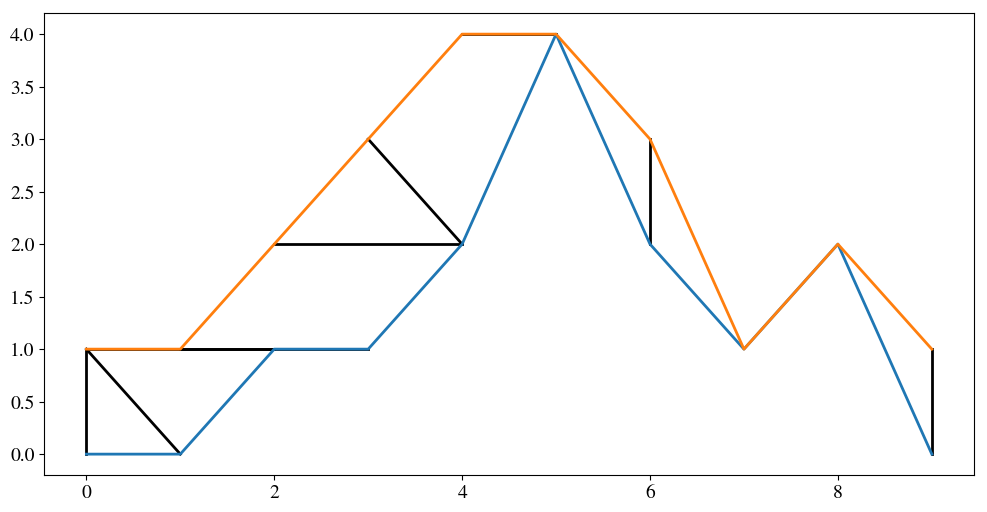

In [54]:
import itertools 

x = np.array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 3, 4, 4, 3, 1, 2, 1]).reshape(-1, 1)
distance, path2 = fastdtw(x, y, dist=euclidean)

fig=plt.figure()
ax=fig.add_subplot(111)
for i, j in path2:
    plt.plot((i, j), (x[i], y[j]), color = 'black')
plt.plot(x)
plt.plot(y)

## Let's download some stock index data from Yahoo



```
pip install pandas-datareader 
pip install yahoo-finance 
pip install fix_yahoo_finance --upgrade --no-cache-dir
```

In [61]:
from pandas_datareader.data import DataReader
from datetime import datetime

dji = DataReader('^DJI',  'yahoo', datetime(2016,5,1), datetime(2016,6,1))
dji_returns = pd.DataFrame(np.diff(np.log(dji['Adj Close'].values)))
dji_returns.index = dji.index.values[1:dji.index.values.shape[0]]
dji_returns.columns = ['Dow Jones Ind. Returns']

nsdq = DataReader('^IXIC',  'yahoo', datetime(2016,5,1), datetime(2016,6,1))
nsdq_returns = pd.DataFrame(np.diff(np.log(nsdq['Adj Close'].values)))
nsdq_returns.index = nsdq.index.values[1:nsdq.index.values.shape[0]]
nsdq_returns.columns = ['NASDAQ Returns']

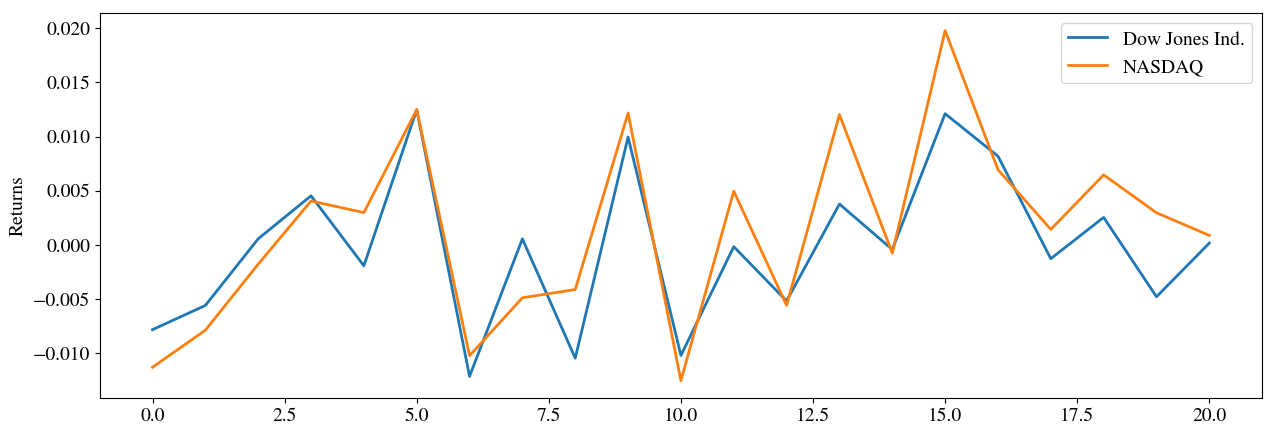

In [62]:
plt.figure(figsize=(15, 5))
plt.ylabel('Returns')
plt.plot(dji_returns['Dow Jones Ind. Returns'].values, label = 'Dow Jones Ind.')
plt.plot(nsdq_returns['NASDAQ Returns'].values, label = 'NASDAQ')
plt.legend()
plt.show()

In [63]:
dist, cost, acc, path = dtw(dji_returns['Dow Jones Ind. Returns'].values, nsdq_returns['NASDAQ Returns'].values, dist=euclidean)
print('Minimum distance found:', dist)

Minimum distance found: 0.0016267348914


(-0.5, 20.5)

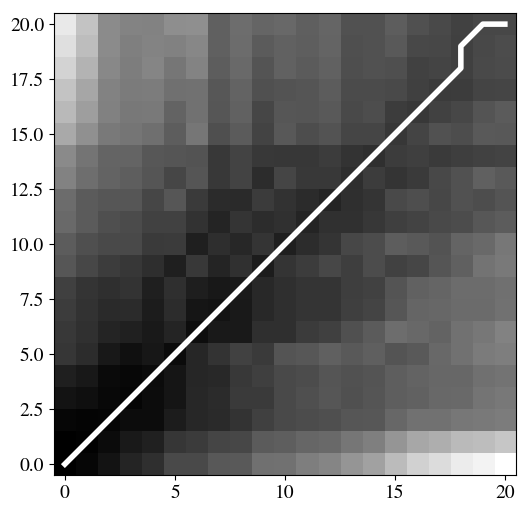

In [64]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"),  interpolation='nearest')
plt.plot(path[0], path[1], 'w',  linewidth=4.0 )
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

In [65]:
distance, path2 = fastdtw(dji_returns['Dow Jones Ind. Returns'].values, nsdq_returns['NASDAQ Returns'].values, dist=euclidean)
print('Minimum distance found:', distance)

Minimum distance found: 0.06832286543898647


In [66]:
print (path2)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (18, 19), (19, 20), (20, 20)]


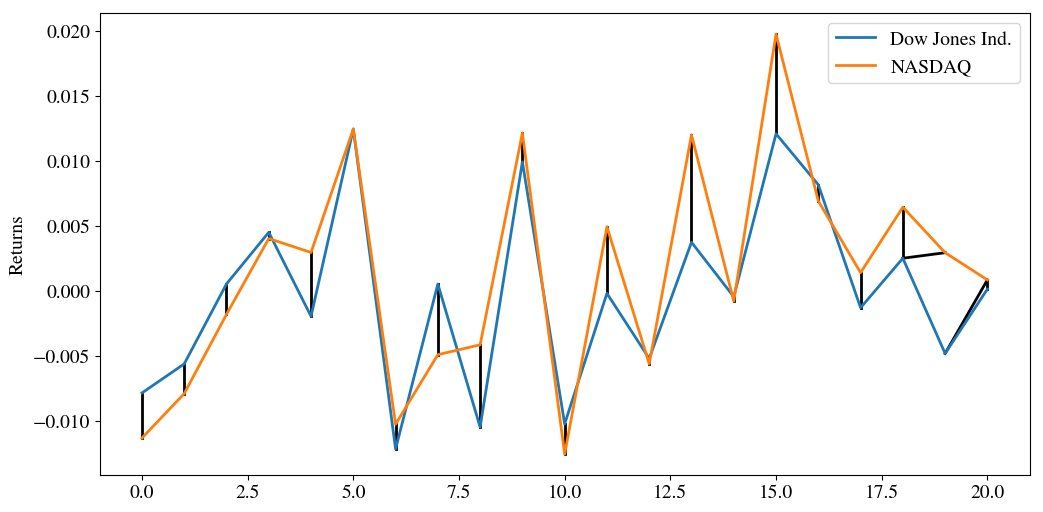

In [67]:
x = dji_returns['Dow Jones Ind. Returns'].values
y = nsdq_returns['NASDAQ Returns'].values
fig=plt.figure()
ax=fig.add_subplot(111)
for i, j in path2:
    plt.plot((i, j), (x[i], y[j]), color = 'black')
plt.ylabel('Returns')
plt.plot(x, label = 'Dow Jones Ind.')
plt.plot(y, label = 'NASDAQ')
plt.legend()
plt.show()

In [68]:
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()

<a id='Kmeans-clustering'></a>


K-Means Clustering
==========
[Back to top](#top)

-----

- K-means clustering is a simple and elegant approach for partitioning a data set into K distinct, non-overlapping clusters. To perform K-means clustering, we must first specify the desired number of clusters K.

- K-means problem is solved using Lloyd’s algorithm. Lloyd's algorithm finds local optimum not global. That’s why it can be useful to restart it several times. [Scikit-learn does this for you]

- Following objective function says that we want to partition the observations into K clusters such that the total within-cluster variation, summed over all K clusters, is as small as possible. [Within-cluster variation is called inertia in scikit learn]


### $$\underset{C_1,...,C_K}{minimize}\left \{ \sum_{k=1}^{K} \frac{1}{|C_k|} \sum_{i,{i}'\in C_k }^{ }\sum_{j=1}^{p} (x_{ij}-x_{{i}'j})^2 \right \}$$


## Algorithm - K-Means Clustering  ##

- Randomly assign a number, from 1 to K, to each of the observations. These serve as initial cluster assignments for the observations. 

- Iterate until the cluster assignments stop changing:

    - (a) For each of the K clusters, compute the cluster centroid. The kth cluster centroid is the vector of the p feature means for the observations in the kth cluster.

    - (b) Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance).


#### We will take an example from An Introduction to Statistical Learning, Textbook by Gareth James, Robert Tibshirani, and Trevor Hastie. We will do manual calculations and then run it on Scikit learn.   "ISLR Book - Chapter 10 Exercise.3 [R Solution](http://blog.princehonest.com/stat-learning/ch10/3.html)”  #####


In [69]:
X = pd.DataFrame(np.array([[1,4],[1,3],[0,4],[5,1],[6,2],[4,0]]),columns=['X1','X2'])
X

X1  X2
0   1   4
1   1   3
2   0   4
3   5   1
4   6   2
5   4   0

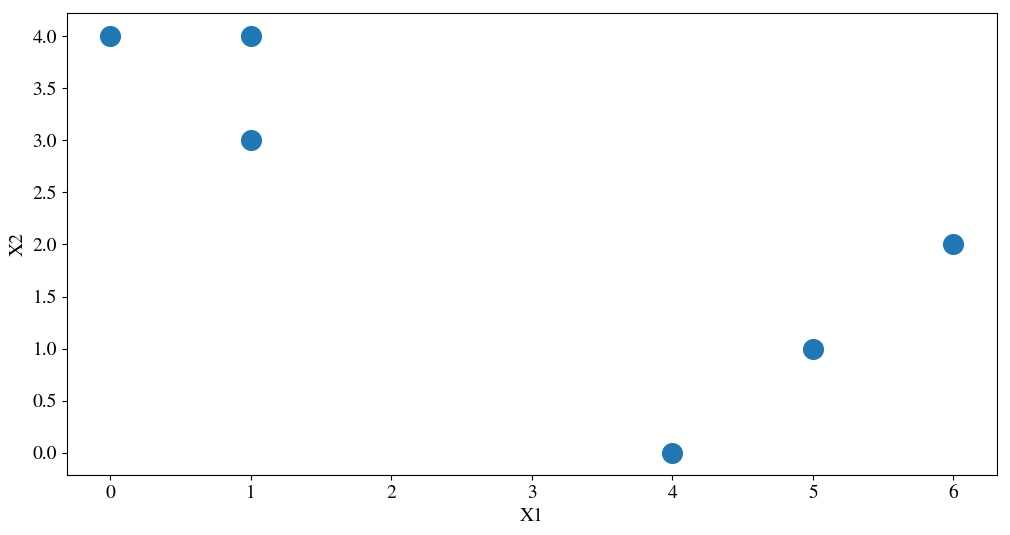

In [70]:
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(X.X1, X.X2, s=200);

In [71]:
X['ClassLabel'] = np.array([1, 1, 2, 2, 1, 2])
X

X1  X2  ClassLabel
0   1   4           1
1   1   3           1
2   0   4           2
3   5   1           2
4   6   2           1
5   4   0           2

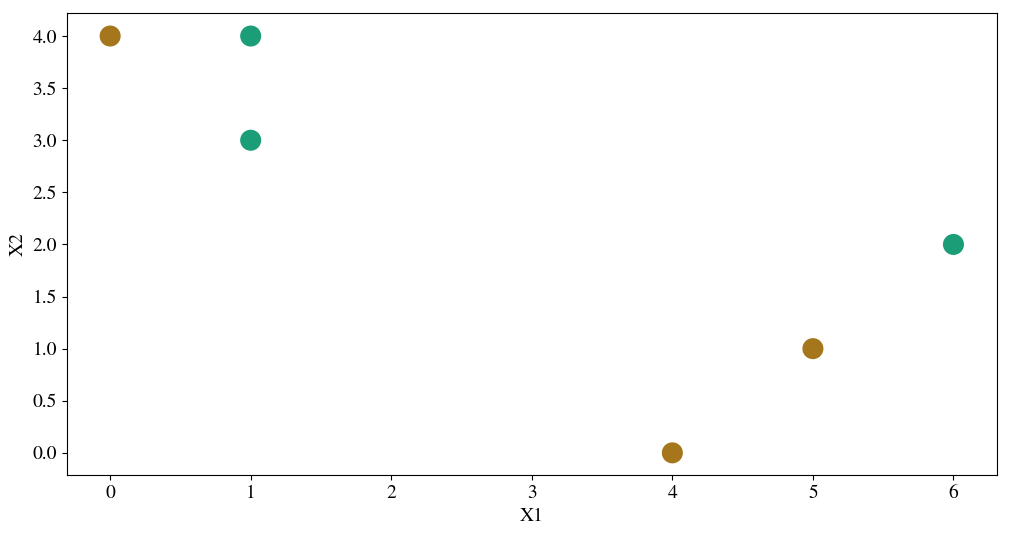

In [72]:
plt.scatter(X.X1, X.X2, s=200, c=X['ClassLabel'], cmap=dark2_cmap)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Step 2: Compute the centroid for each cluster
   
There are two classes, so two centroids:

$centroid1 = [(1+1+6)/3 , (3+4+2)/3 ] = (2.6667, 3)$

$centroid2 = [(0+5+4)/3 , (4+1+0)/3 ] = (3,1.667)$

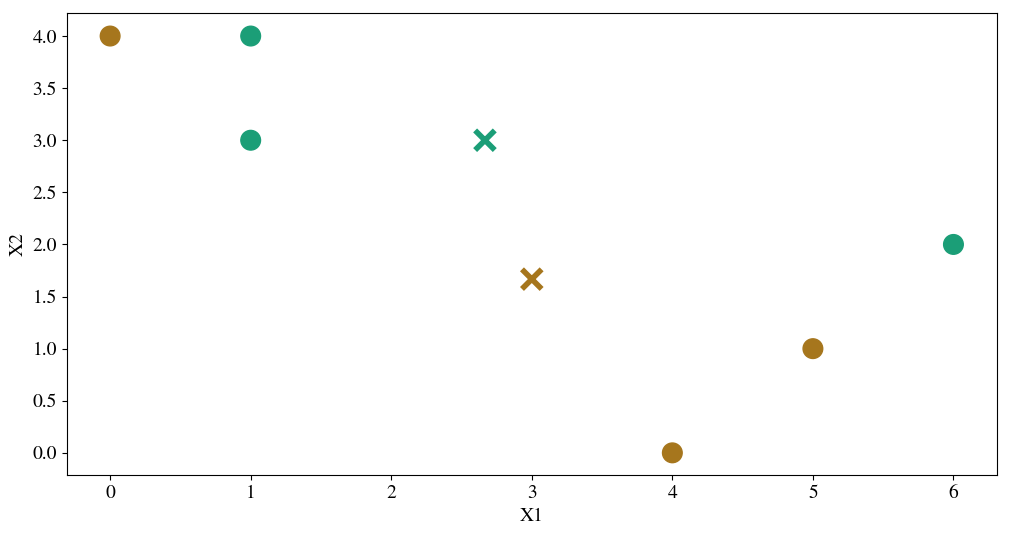

In [73]:
plt.scatter(X.X1, X.X2, s=200, c=X['ClassLabel'], cmap=dark2_cmap)
plt.scatter(np.array([2.6667, 3]), np.array([3,1.667]), s=200, lw=4, c=[1,2], cmap=dark2_cmap, marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

-----

Step 3: Assign each observation to the centroid to which it is closest, in terms of Euclidean Distance. 

$Find\ Euclidean\ Distance$

|Features|Centroid|=|Euclidean Distance|Cluster Assignment|
|-----|---------|-|------|-----|
|(1,4)<br>(1,4)|(2.667,3)<br>(3,1.667)|=|1.9439<br>3.070651|Assign to C1|
|(1,3)<br>(1,3)|(2.667,3)<br>(3,1.667)|=|1.67<br>2.4018|Assign to C1|
|(0,4)<br>(0,4)|(2.667,3)<br>(3,1.667)|=|2.851123<br>3.798539|Assign to C1|
|(5,1)<br>(5,1)|(2.667,3)<br>(3,1.667)|=|3.06651<br>2.1092|Assign to C2|
|(6,2)<br>(6,2)|(2.667,3)<br>(3,1.667)|=|3.47961<br>3.018095|Assign to C2|
|(4,0)<br>(4,0)|(2.667,3)<br>(3,1.667)|=|3.2816<br>1.94651|Assign to C2|


-----

Step 4: Repeat 2 and 3 until the answers stop changing.
        
   Compute the centroid for each cluster

There are two classes, so two centroids:

$centroid1 = [(1+1+0)/3 , (4+3+4)/3 ] = (0.6667, 3.6667)$

$centroid2 = [(5+6+4)/3 , (1+2+0)/3 ] = (5,1)$

----

Step 5: Assign each observation to the centroid to which it is closest, in terms of Euclidean Distance. 

$Find\ Euclidean\ Distance$

|Features|Centroid|=|Euclidean Distance|Cluster Assignment|
|-----|---------|-|------|-----|
|(1,4)<br>(1,4)|(0.6667, 3.6667)<br>(5,1)|=|0.46669<br>5|Assign to C1|
|(1,3)<br>(1,3)|(0.6667, 3.6667)<br>(5,1)|=|0.74686<br>4.47213|Assign to C1|
|(0,4)<br>(0,4)|(0.6667, 3.6667)<br>(5,1)|=|0.74686<br>5.830952|Assign to C1|
|(5,1)<br>(5,1)|(0.6667, 3.6667)<br>(5,1)|=|5.087023<br>0|Assign to C2|
|(6,2)<br>(6,2)|(0.6667, 3.6667)<br>(5,1)|=|5.5854<br>1.414214|Assign to C2|
|(4,0)<br>(4,0)|(0.6667, 3.6667)<br>(5,1)|=|4.9555<br>1.414214|Assign to C2|

<br>
<center>DONE - Cluster assignment didn't change</center>

------

In [74]:
#Final Class labels
X['ClassLabel'] = np.array([1, 1, 1, 2, 2, 2])
X

X1  X2  ClassLabel
0   1   4           1
1   1   3           1
2   0   4           1
3   5   1           2
4   6   2           2
5   4   0           2

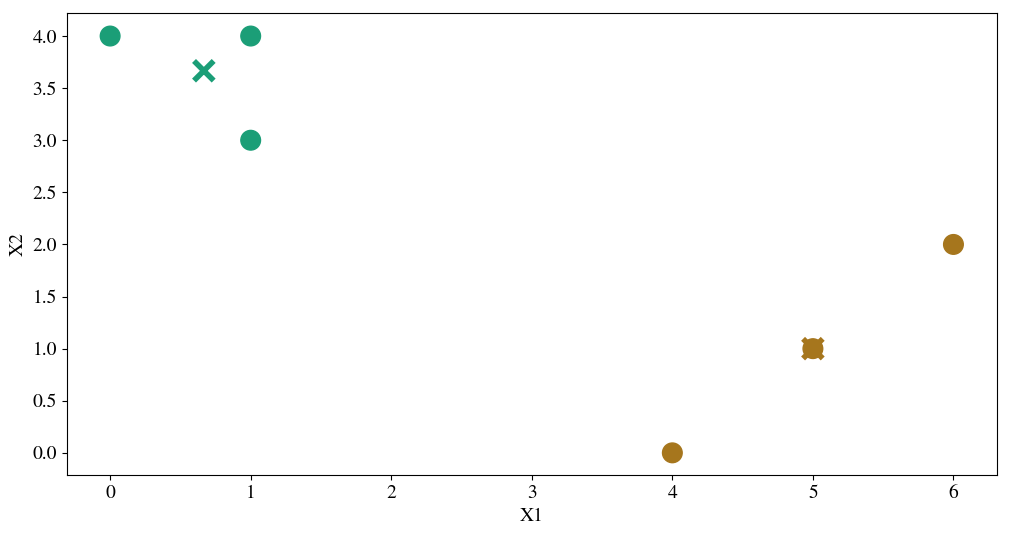

In [75]:
plt.scatter(X.X1, X.X2, s=200, c=X['ClassLabel'], cmap=dark2_cmap)
plt.scatter(np.array([0.6667, 5]), np.array([3.6667,1]), s=200, c=[1,2], lw=4, cmap=dark2_cmap, marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [76]:
#Above example on Scikit Learn
X = np.array([[1,4],[1,3],[0,4],[5,1],[6,2],[4,0]])
kmeans = KMeans(n_clusters=2, random_state=10,n_init=10).fit(X)
#n_init=1 => Do NOT use this except for this demo.  
#n_init is Number of time the k-means algorithm will be run with different centroid seeds. 
#The final results will be the best output of n_init consecutive runs in terms of inertia.(sum of within cluster variation)

#If you change random_state - you may get different cluster assignments than the calculation above. 
print(kmeans.labels_)

[0 0 0 1 1 1]


In [77]:
print(kmeans.cluster_centers_)

[[ 0.66666667  3.66666667]
 [ 5.          1.        ]]


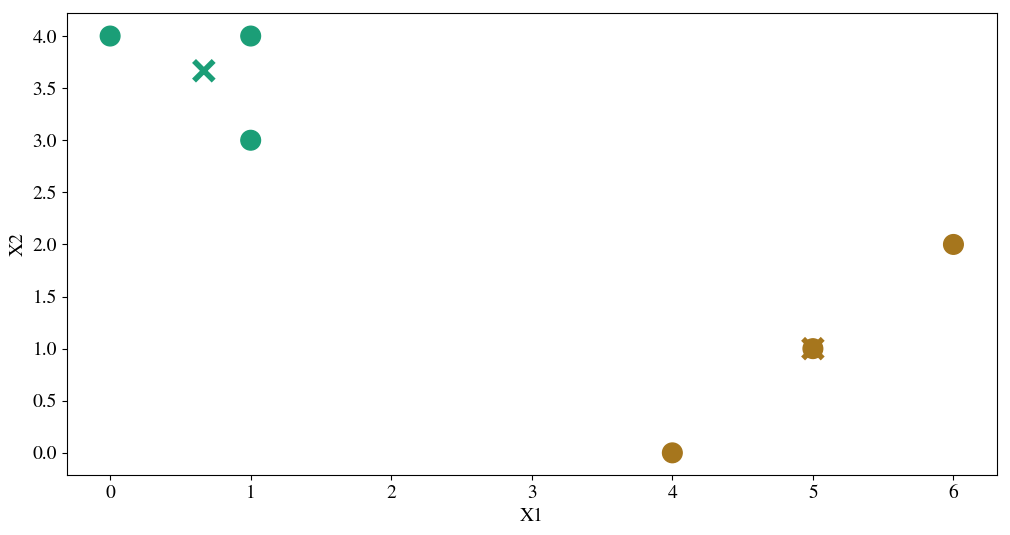

In [78]:
plt.scatter(X[:,0], X[:,1], s=200, c=kmeans.labels_, cmap=dark2_cmap)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c=[1,2], lw=4, cmap=dark2_cmap, marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [79]:
kmeans.inertia_

5.3333333333333339

----
```
Sum of within cluster variation (inertia)  [Based on objective function mentioned earlier]  

Pair wise distance (Squared) for cluster 1  

(1,4)(1,3)=1  
(1,4)(0,4)=1
(1,3)(0,4)=2  

Pair wise distance (Squared) for cluster 2  

(5,1)(6,2)=2
(5,1)(4,0)=2
(6,2)(4,0)=8

4/3 + 12/3 =  5.333    Divide by 3 - because we have 3 samples in each cluster
```
------

Application  - K-means clustering of the Iris dataset 
=====================

---

In [80]:
iris = datasets.load_iris()
#print (iris.DESCR)

In [81]:
irisDF = pd.DataFrame(iris.data, columns = iris.feature_names)
irisDF['label'] =[iris.target_names[i] for i in iris.target]
irisDF.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

    label  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa

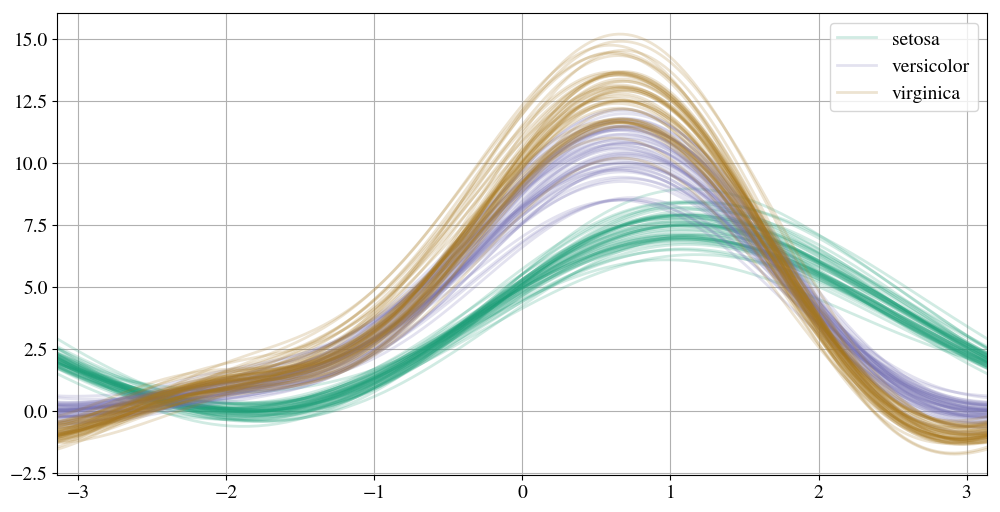

In [82]:
andrews_curves(irisDF, 'label', alpha=0.2, colormap=dark2_cmap)
plt.show()

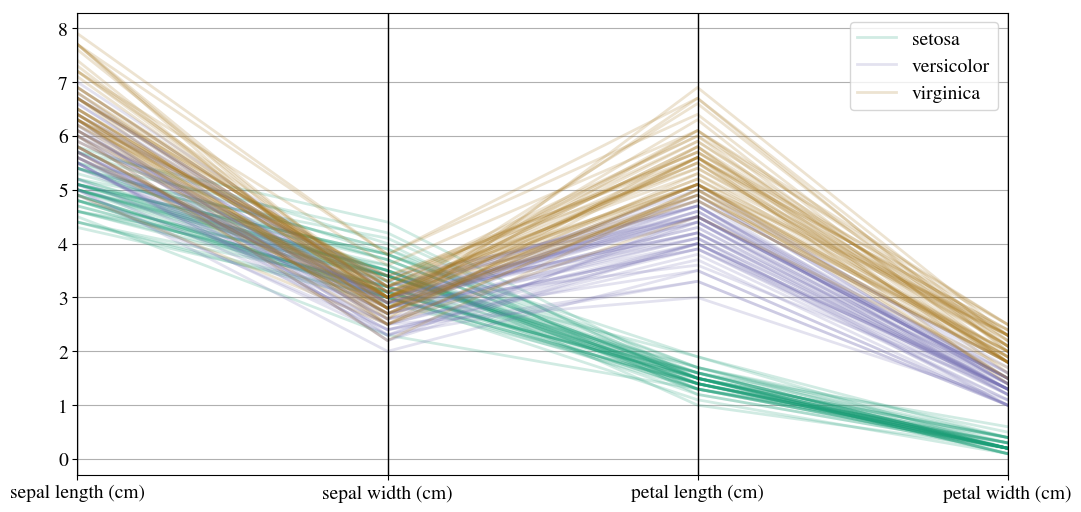

In [83]:
parallel_coordinates(irisDF, 'label', alpha=0.2, colormap=dark2_cmap)
plt.show()

In [84]:
set_mpl_params()
rcParams['figure.dpi'] = 70

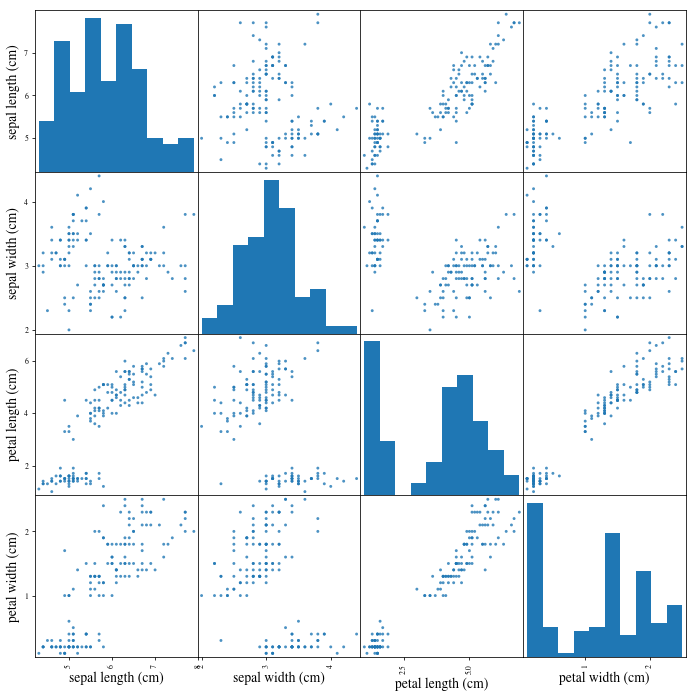

In [85]:
scatter_matrix(irisDF, alpha=0.8, figsize=(12, 12), diagonal='hist')
plt.show()

Critical aspects of K-means
======

- Choice of K
- Initial conditions - the location of starting cluster centers
- Distance function - usually Euclidean distance
- Issues: Missing values; differing scales; qualitative/nominative/categorical variables


Create a few estimators to see the differences between using different numbers of clusters.  The [KMeans](http://scikit-learn.org/stable/modules/clustering.html#k-means) API is well documented and very simple to use.  

In [86]:
X = iris.data
Y = iris.target   #We will be using this only for plotting, not for clustering - unsupervised learning


print(X.shape, Y.shape)

(150, 4) (150,)


In [87]:
mpl.rcParams.update(mpl.rcParamsDefault)

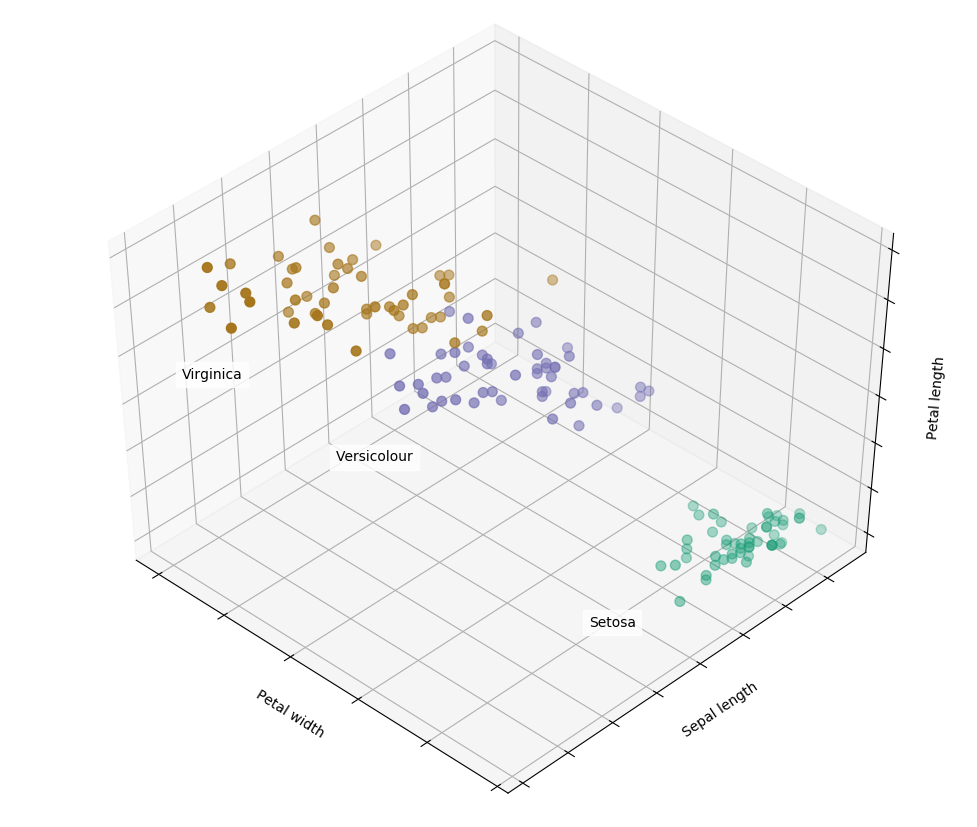

In [88]:
# Plot the ground truth
fig = plt.figure(1, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=45, azim=134)

plt.cla()

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[Y == label, 3].mean(),
              X[Y == label, 0].mean() + 1.5,
              X[Y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.8, edgecolor='w', facecolor='w'))
    
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=Y, s = 50, cmap=dark2_cmap)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

In [89]:
rnd_state = 12
estimators = {'k_means_iris_3': KMeans(n_clusters=3,n_init=10,
                                              init='random', random_state=rnd_state),
              'k_means_iris_8': KMeans(n_clusters=8, random_state=rnd_state),
              'k_means_iris_bad_init': KMeans(n_clusters=3, n_init=1,
                                              init='random', random_state=rnd_state)}

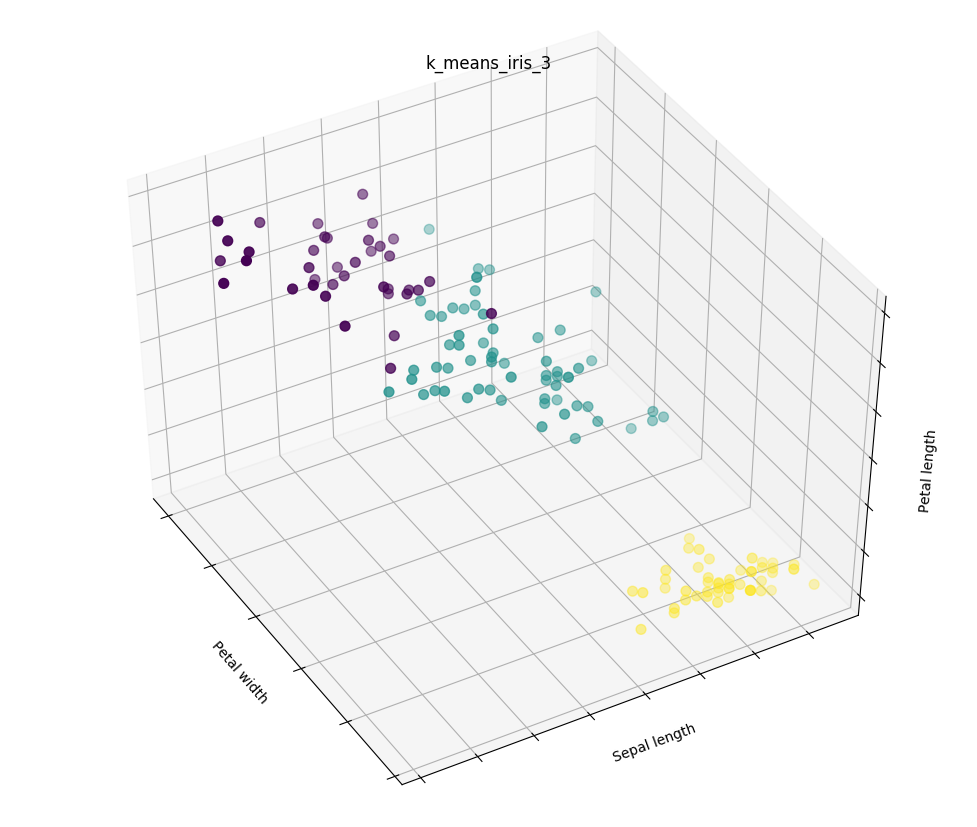

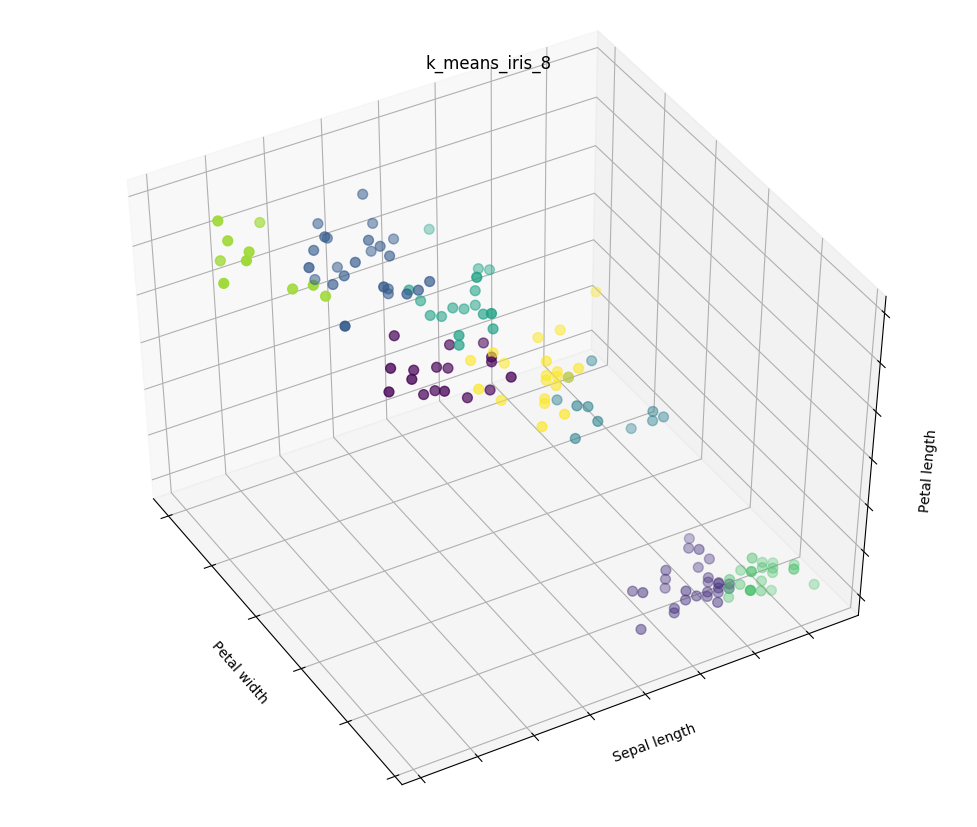

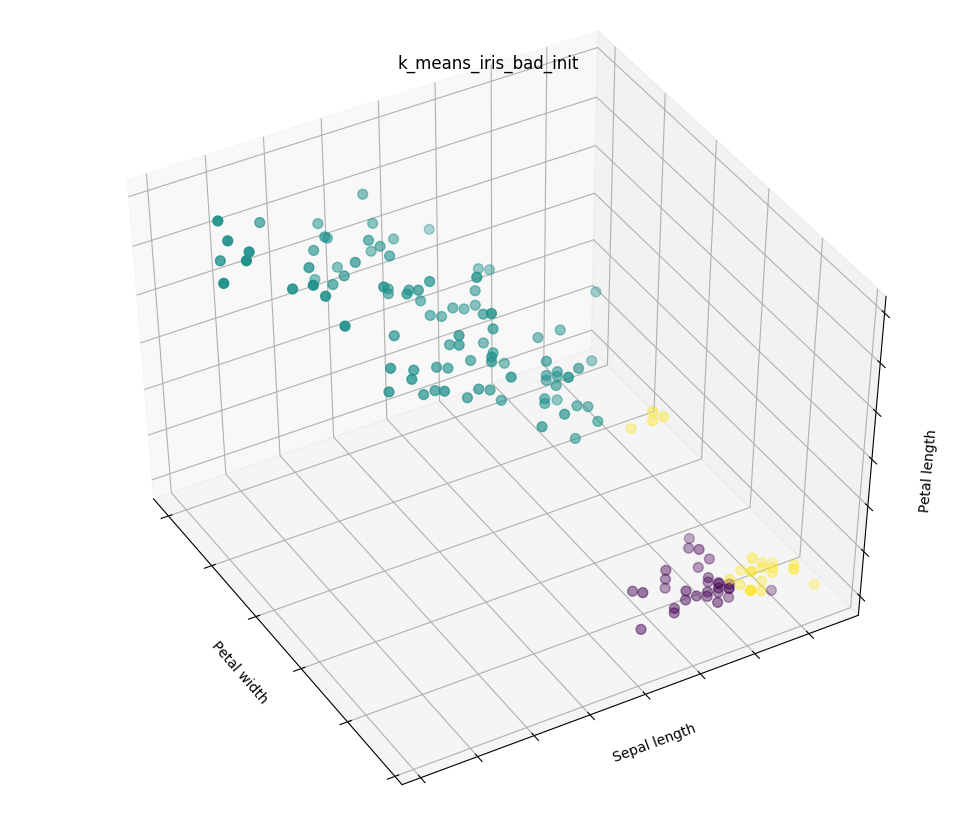

In [90]:
fignum = 1

for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(10, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=45, azim=150)

    plt.cla()
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), s=50)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(name)
    plt.show()
    fignum = fignum + 1

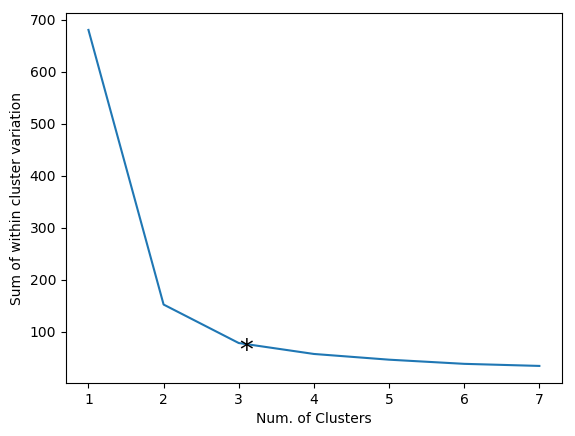

In [91]:
#Evaluating K-Means / How to choose K / Elbow plot

#Goal is to minimize total within cluster variation (inertia)
maxk = 8
arr = np.array(maxk*[0])

for k in range(1,maxk):
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=0).fit(X)
    arr[k-1]=kmeans.inertia_

fig, ax = plt.subplots()
plt.xlabel("Num. of Clusters")
plt.ylabel("Sum of within cluster variation")
plt.annotate("*",(3,arr[2]-30),size = 20)
plt.plot(range(1,maxk),arr[:maxk-1])
plt.show()

<a id='Silhouette-plots'></a>


Silhouette plots
==========
[Back to top](#top)

-----

[Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) from Scikit-learn.

We can use the silhouette score to evaluate a particular cluster model. Silhouette scores can be used to help evaluate the appropriate number of clusters that are truly in the data. The value that is returned is an indicator of how closely grouped the data is.

The Silhouette Coefficient for each point is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample point. The Silhouette Coefficient for a point is:  

$$\frac{(b - a)}{ \max (a, b)} $$

The score that is reported is the average of all the sample points.

To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.  

This function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use silhouette_samples.  

#### Interpretation
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
Values close to 1 mean that the data are appropriately clustered. If the returned value is close to -1 then the data more likely belongs in the neighboring cluster. A value of 0 indicates that the data resides on the border of two natural clusters.

In [92]:
from sklearn.metrics import silhouette_score

In [93]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, random_state=0).fit(X)
    classes = kmeans.predict(X)
    print(silhouette_score(X, classes, metric='euclidean'))

0.680813620271
0.552591944521
0.497825690075
0.492855591798
0.368205696538


For n_clusters = 2 the average silhouette_score is 0.680813620271


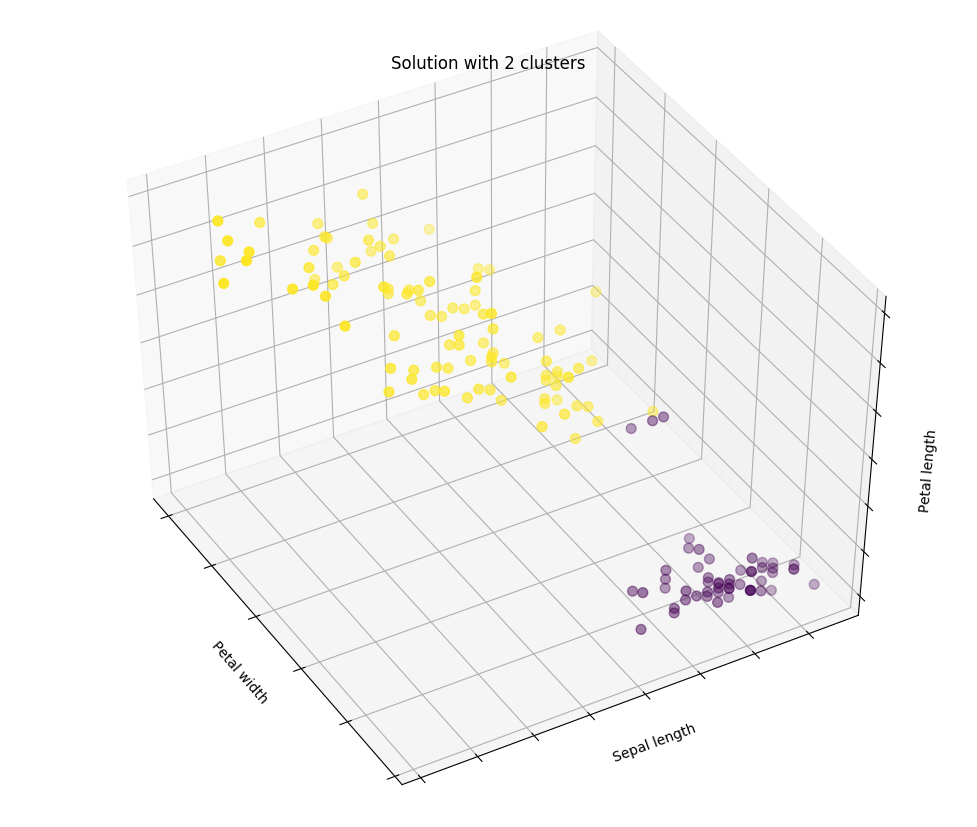

For n_clusters = 3 the average silhouette_score is 0.552591944521


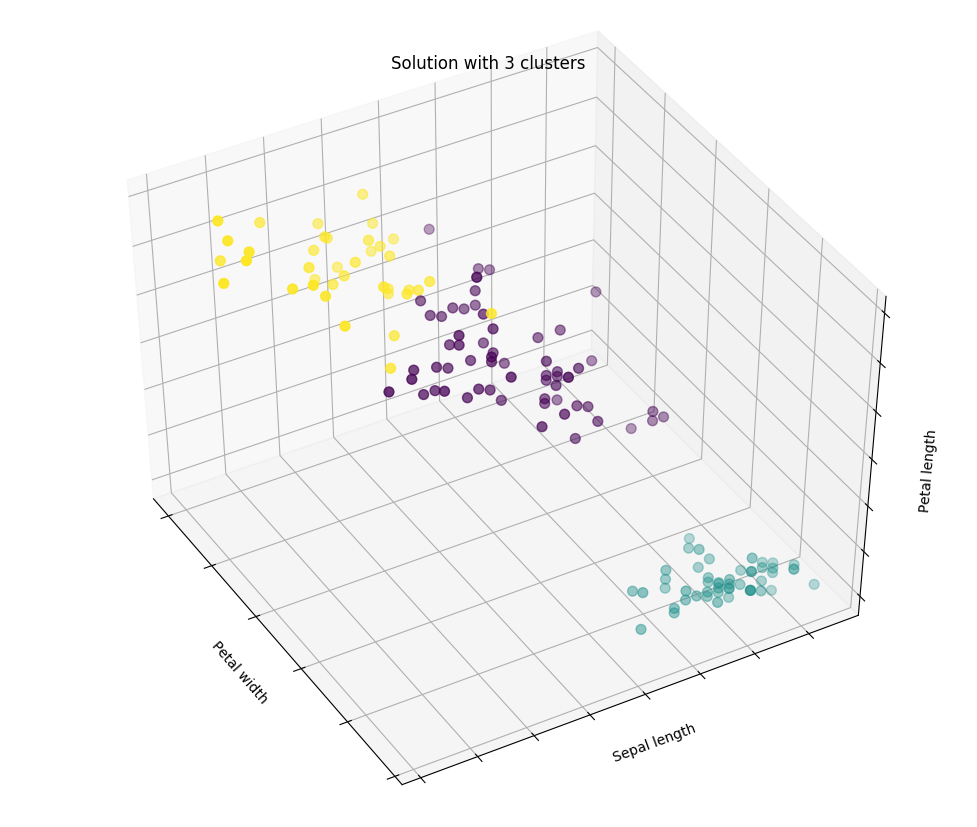

For n_clusters = 4 the average silhouette_score is 0.497825690075


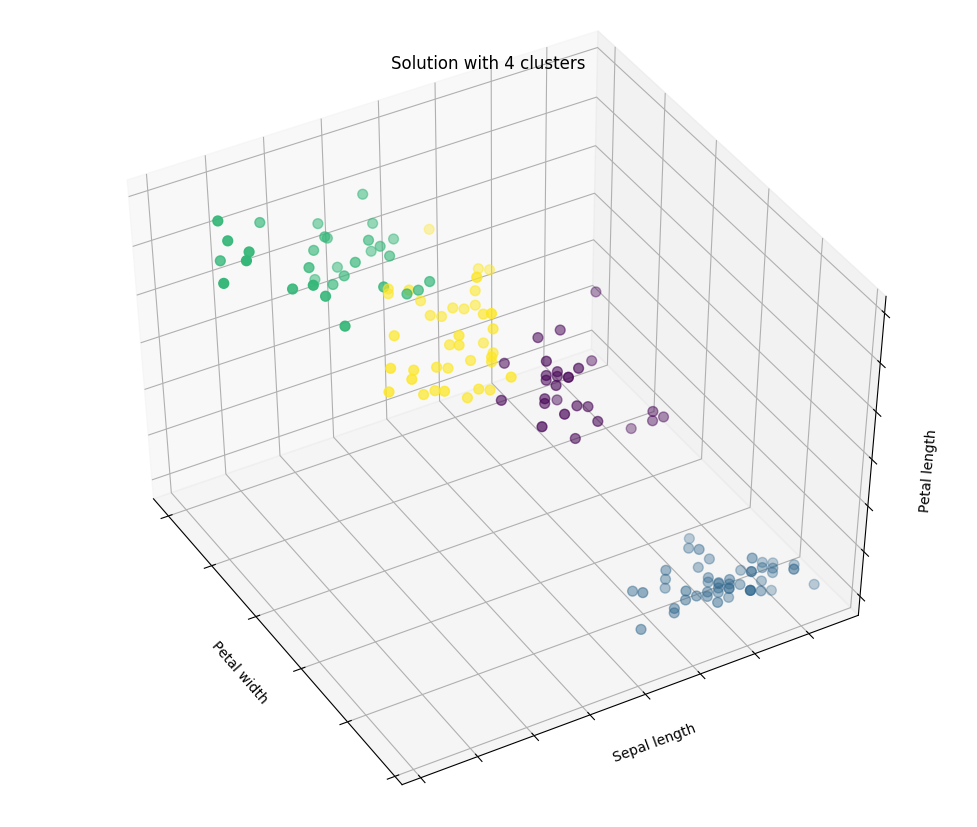

For n_clusters = 5 the average silhouette_score is 0.492855591798


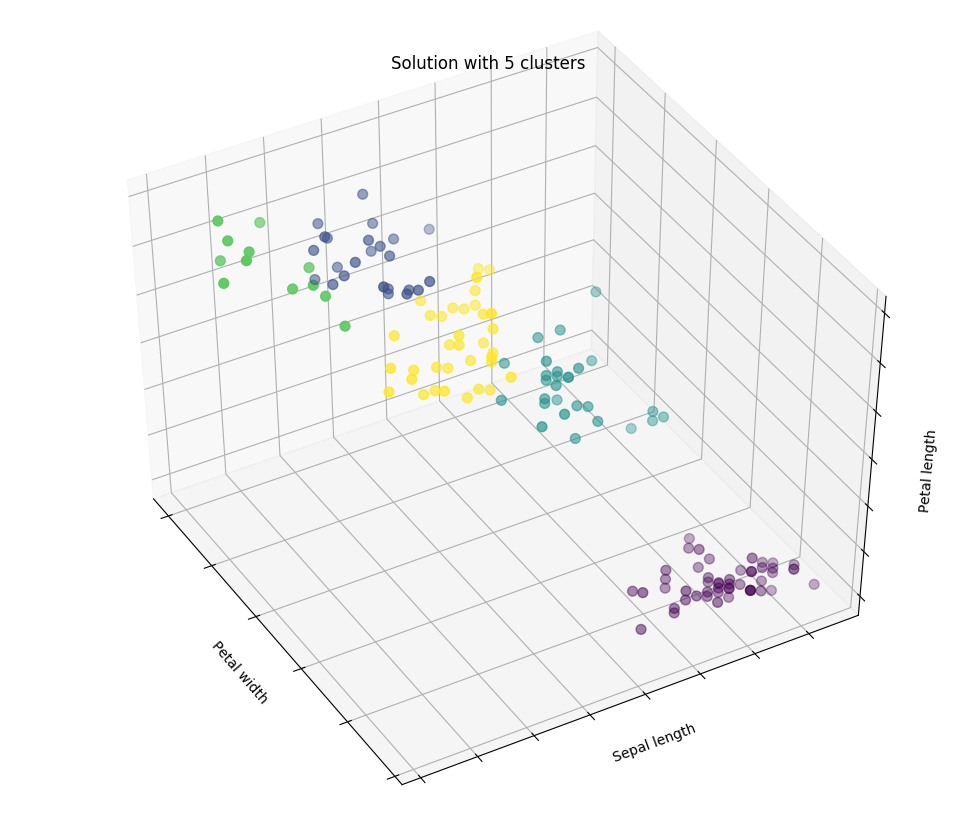

For n_clusters = 6 the average silhouette_score is 0.368205696538


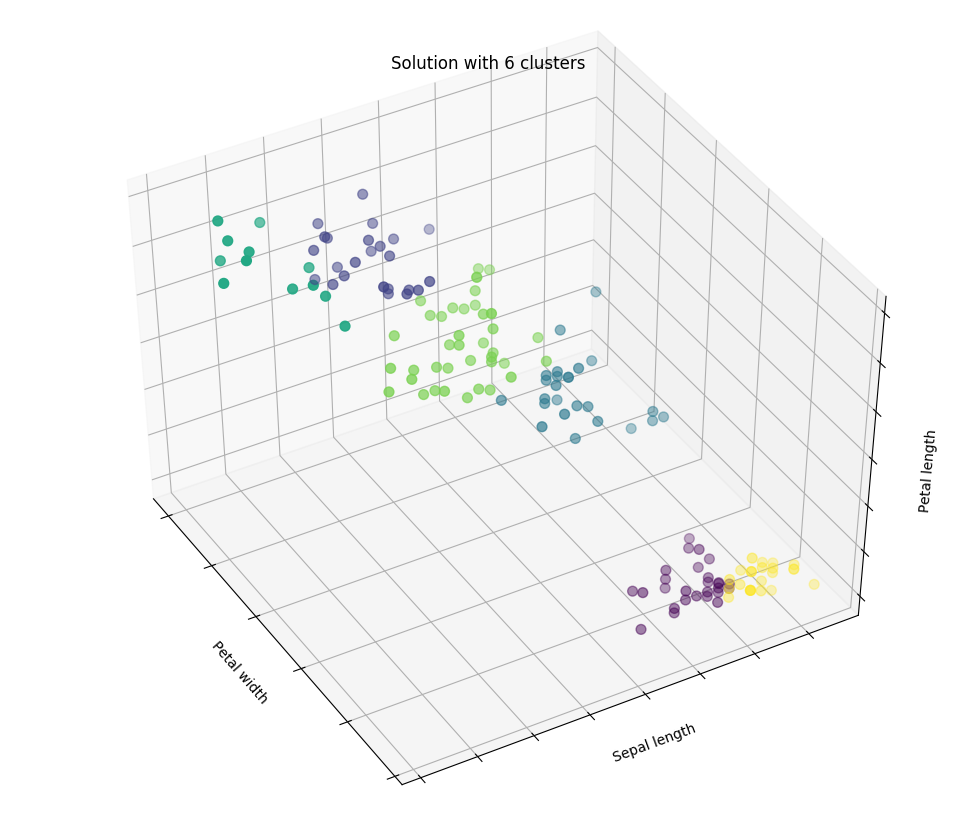

In [94]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, random_state=0).fit(X)
    classes = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, classes)
    print('For n_clusters =', n_clusters, 'the average silhouette_score is', silhouette_avg)
    
    fig = plt.figure(figsize=(10, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=45, azim=150)

    plt.cla()

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=classes, s=50)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    plt.title('Solution with %d clusters' % (n_clusters))
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.680813620271


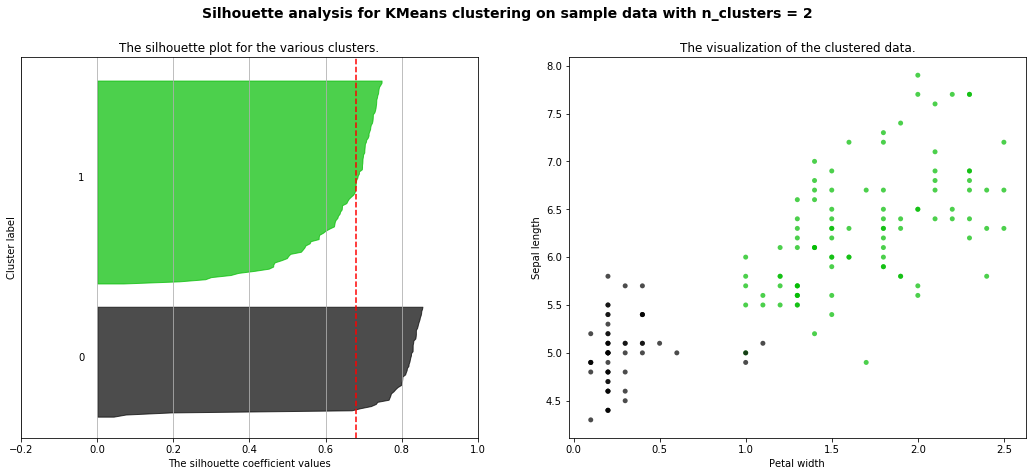

For n_clusters = 3 The average silhouette_score is : 0.552591944521


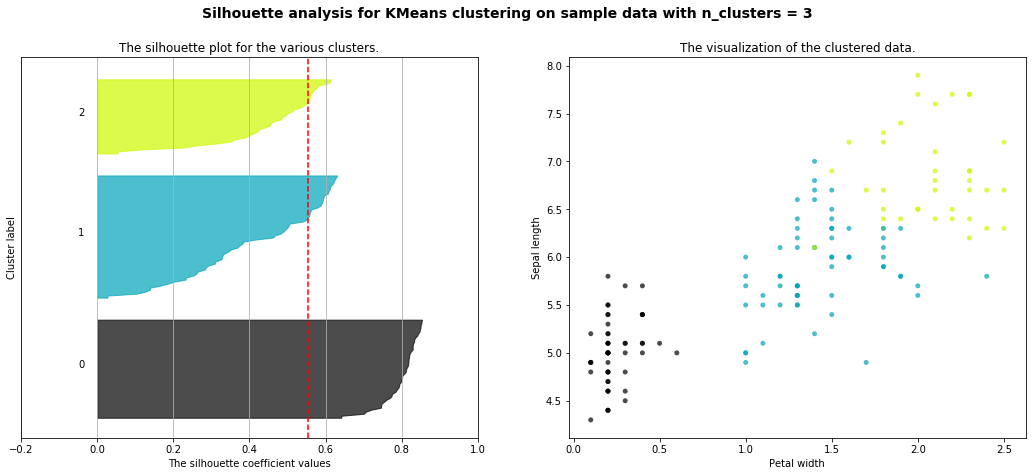

For n_clusters = 4 The average silhouette_score is : 0.497825690075


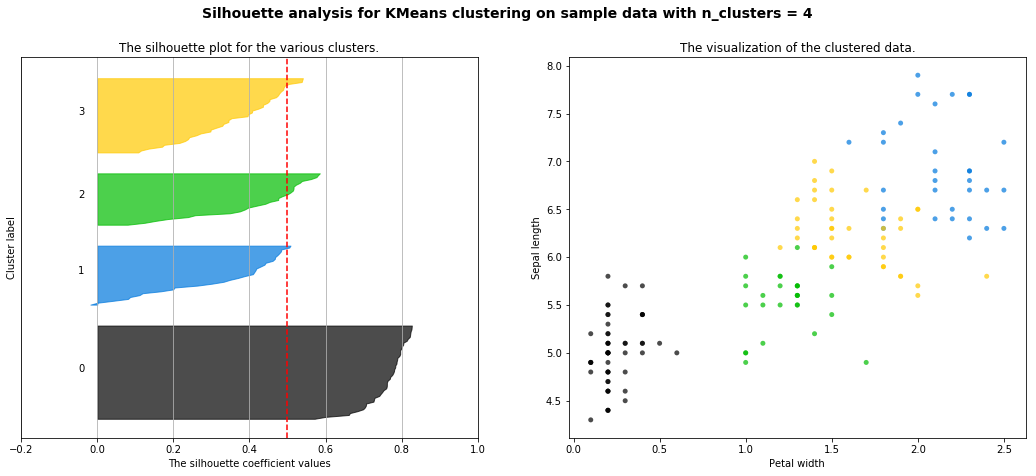

For n_clusters = 5 The average silhouette_score is : 0.488517550854


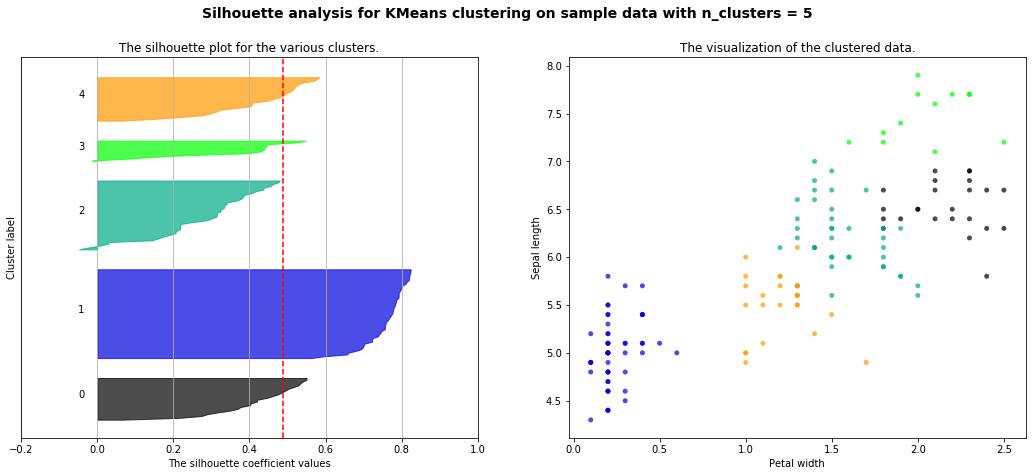

For n_clusters = 6 The average silhouette_score is : 0.371218050256


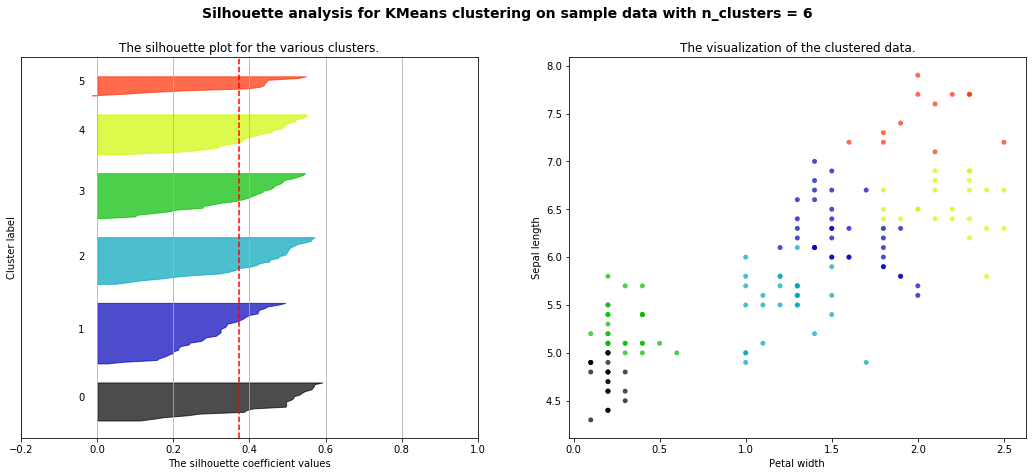

For n_clusters = 7 The average silhouette_score is : 0.360059799443


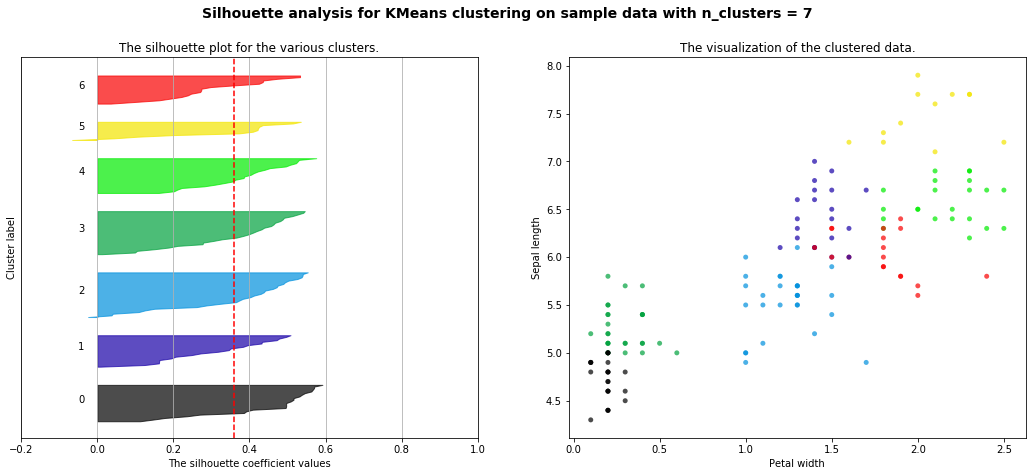

For n_clusters = 8 The average silhouette_score is : 0.36037497064


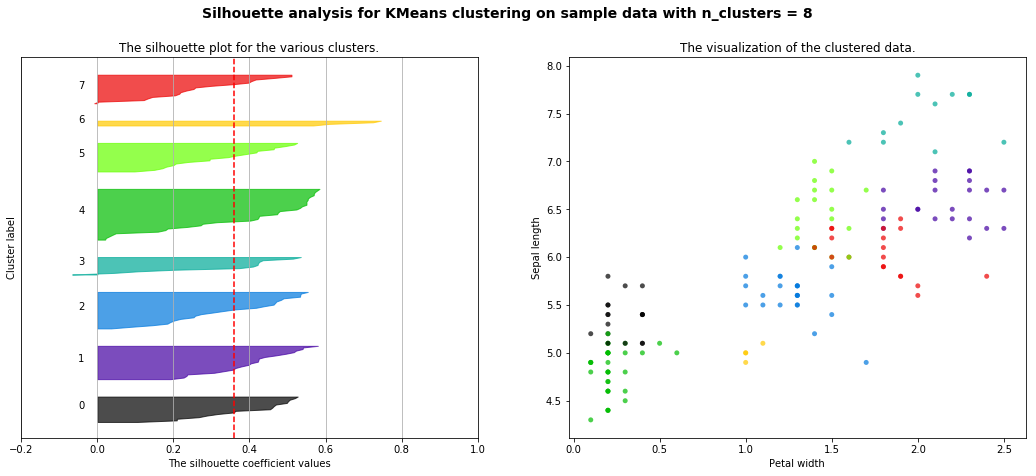

For n_clusters = 9 The average silhouette_score is : 0.313931023397


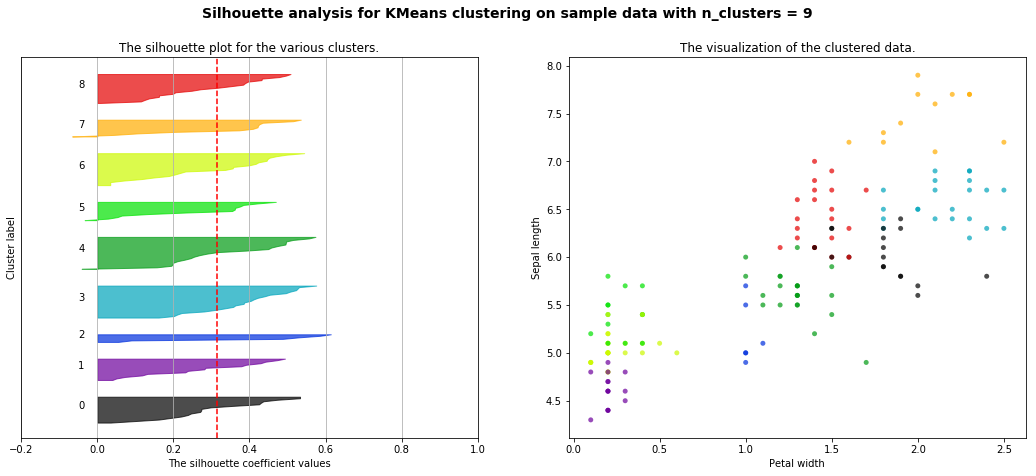

For n_clusters = 10 The average silhouette_score is : 0.308014583084


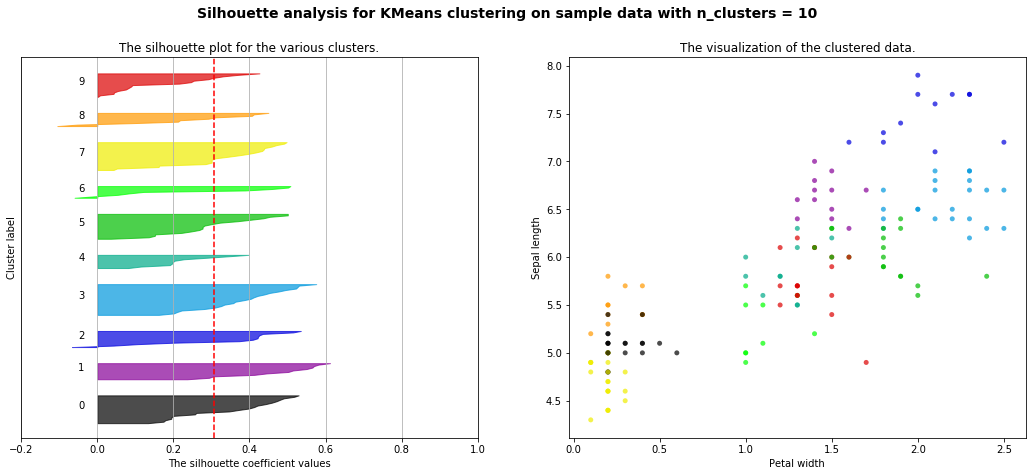

In [95]:
# Taken from the SciKit Learn website examples
# Plots the solhouette scores to check the selection of clusters
from sklearn.metrics import silhouette_samples


def make_silhouette(X_in):
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_in) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X_in)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_in, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_in, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        #ax1.yaxis.set_ticks_position('none')
        #ax1.xaxis.set_ticks_position('none')
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.xaxis.grid(True)
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Draw white circles at cluster centers
        centers = clusterer.cluster_centers_
        
        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        
        ax2.scatter(X_in[:, 3], X_in[:, 0], marker='.', s=100, lw=0, alpha=0.7, c=colors)
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel('Petal width')
        ax2.set_ylabel('Sepal length')
        ax2.grid(False)

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        #remove_border()
        plt.show()
        
# run the silhouette plotting function
#%matplotlib osx
%matplotlib inline
make_silhouette(X)
mpl.rcdefaults()
set_mpl_params()